### 함수 저장소

1. 학습 데이터셋 비교 가시화

visualize_multiple_dataloaders([test_loader], test_loader, images_per_loader=5)

2. 실험 진행용 학습모델 저장

### Neural Network Master Switch Board

In [1]:
# Neural Network Retrain Option
#모델/데이터 전체 리셋
Data_Reset = False
#학습된 모델 없등면 자동으로 학습
Auto_Init = True
defualt_epoch = 25
#Model Save Path
default_path = "default_path_epoch_25_tuned"
#로그 기록 여부
log_save = True
## Switch Baord based on stage
poision_sys_reset = False
restore_sys_reset = False
reclass_sys_reset = False
multiplier_sys_reset = False
##Muliplier_sys_reset by Type
M_reset_auto_10 =False
M_reset_unet_10 =False
M_reset_auto_attacked =False
M_reset_unet_attacked =False
M_reset_auto_100 =False
M_reset_unet_100 = False
# CUDA 이용 GPU 번호 입력 (Default : 0)
GPU_NUM = 1

### 1. 라이브러리 불러오기

In [2]:
import os
import shutil
import random
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc


import torchvision
from torchvision.datasets import CIFAR10
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from torchvision import transforms


# Visualization
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

In [3]:
if torch.cuda.is_available():
    if GPU_NUM > (torch.cuda.device_count() - 1):
        GPU_NUM = torch.cuda.device_count() - 1
    device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print('Current cuda device:', torch.cuda.current_device())
    print('Count of using GPUs:', torch.cuda.device_count())
else:
    device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Current cuda device: 1
Count of using GPUs: 2
Using device: cuda:1


##### Automated Git Ignore 

In [4]:
def gitignore(directory = default_path, gitignore_path=".gitignore"):

    # .gitignore 파일이 존재하는지 확인
    if not os.path.exists(gitignore_path):
        print(f"{gitignore_path} 파일이 존재하지 않습니다. 새로 생성합니다.")
        with open(gitignore_path, 'w') as f:
            f.write("")  # 빈 .gitignore 파일 생성
    
    # .gitignore 파일을 읽기
    with open(gitignore_path, 'r') as f:
        lines = f.readlines()

    # 이미 디렉토리가 .gitignore에 있는지 확인
    ignore_line = f"{directory}/\n"
    if ignore_line not in lines:
        # 디렉토리가 없으면 추가
        with open(gitignore_path, 'a') as f:
            f.write(ignore_line)
        print(f"{directory} 디렉토리를 .gitignore에 추가했습니다.")
    else:
        print(f"{directory} 디렉토리가 이미 .gitignore에 존재합니다.")


### 2. 데이터셋 정의 - 비오염

In [5]:
# Data loading and transformations
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomCrop(32, padding=4),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Use PyTorch's torchvision.transforms.ToTenesor() to convert the dataset to tensor format
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
add_set = CIFAR100(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Use PyTorch's DataLoader to divide the dataset into mini-batches and load the data
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=64, shuffle=False)
add_loader = DataLoader(dataset=add_set, batch_size=64, shuffle=False)

In [8]:
def visualize_multiple_dataloaders(dataloaders, trainloader, images_per_loader=5):
    num_loaders = len(dataloaders)
    classes = trainloader.dataset.classes

    # 플롯 크기 설정
    plt.figure(figsize=(8,8))

    for i, loader in enumerate(dataloaders):
        # 각 DataLoader에서 배치 하나 가져오기
        batch = next(iter(loader))
        if len(batch) == 2:
            images, labels = batch
        elif len(batch) == 4:\
            _ , _, images, labels = batch
        images = torch.clamp(images, 0, 1)  # 이미지를 0과 1 사이로 클리핑하여 표시 문제 방지

        # 각 DataLoader에서 선택한 이미지 수만큼 시각화
        for j in range(images_per_loader):
            idx = i * images_per_loader + j
            plt.subplot(num_loaders, images_per_loader, idx + 1)
            plt.imshow(images[j].permute(1, 2, 0))  # 이미지 차원 변경: (C, H, W) -> (H, W, C)
            plt.title(classes[labels[j].item()])
            plt.axis('off')

    plt.tight_layout()
    plt.show()

### 3. 신경망 코딩

#### 3.1. ResNet50

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

#### 3.2. Autoencoder 모델 정의

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder 부분
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128)  # latent space (압축된 표현)
        )
        
        # Decoder 부분
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16x16 -> 32x32
            nn.Tanh()  # 0~1 범위로 출력
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### 3.3. U-Net 모델 정의

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # 인코더 (Contracting Path)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        )
        
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        )
        
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        )

        # 병목층 (Bottleneck)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # 디코더 (Expanding Path)
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 4x4 -> 8x8
        )
        
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 8x8 -> 16x16
        )
        
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')  # 16x16 -> 32x32
        )
        
        # 최종 출력 레이어
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)  # 출력 채널 3 (RGB 이미지)

    def forward(self, x):
        # 인코더
        enc1 = self.encoder(x)
        enc2 = self.encoder_2(enc1)
        enc3 = self.encoder_3(enc2)
        
        # 병목층
        bottleneck = self.bottleneck(enc3)
        
        # 디코더
        dec1 = self.decoder_1(bottleneck)
        dec2 = self.decoder_2(dec1)
        dec3 = self.decoder_3(dec2)
        
        # 최종 출력
        out = self.final_conv(dec3)
        return out


### 4. 신경망 학습과 테스트 진행

#### Generic Train and evaluate function

In [12]:
# Train and evaluate function
def train_and_evaluate(model, train_loader, test_loader, device = device, epochs=defualt_epoch, \
                       Data_Reset = Data_Reset, net_reset = False, folder_path = default_path, \
                       net_name = "defual_net.pt", log_save = log_save, log_name = "default_log"):
  
  if os.path.exists(folder_path)== False:
    print("디렉토리 없음")
    if net_reset == False and Data_Reset == False and Auto_Init == False:
      return
  
    os.mkdir(folder_path)
    print("디렉토리를 만들었습니다 : ", folder_path)
    gitignore(directory = folder_path)
  
  os.chdir(folder_path)

  if os.path.exists(net_name) == False and Auto_Init == False:
      print("학습데이터 없음")
      os.chdir("../")
      return

  if net_reset == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):

    model.train()

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

    accuracies = []

    # DataLoader에서 데이터 항목 개수 확인
    for batch in train_loader:
        num_items = len(batch)  # 배치에서 항목 개수 확인
        print("Number of Data Type:", num_items)
        break

    for epoch in range(epochs):
      running_loss = 0.0

      if num_items == 2:
        for data in train_loader:
            original_images, original_labels = data
            original_images, original_labels = original_images.to(device), original_labels.to(device)

            optimizer.zero_grad()

            outputs = model(original_images)
            loss = criterion(outputs, original_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      
      elif num_items == 4:
        for data in train_loader:
            _, _, poisoned_images, poisoned_labels = data
            poisoned_images, poisoned_labels = poisoned_images.to(device), poisoned_labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(poisoned_images)

            # 손실 계산
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      elif num_items == 5:
        for data in train_loader:
            _, _, _, poisoned_labels, restored_images = data
            restored_images, poisoned_labels = restored_images.to(device), poisoned_labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(restored_images)

            # 손실 계산
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      elif num_items == 6:
        for data in train_loader:
            _, _, _, poisoned_labels, _,  restored_images = data
            restored_images, poisoned_labels = restored_images.to(device), poisoned_labels.to(device)

            optimizer.zero_grad()

            # 모델 예측
            outputs = model(restored_images)

            # 손실 계산
            loss = criterion(outputs, poisoned_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
      else :
          print("dataset error")
          os.chdir("../")
          return 
        
      print(f'[Epoch {epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

      accuracy = evaluate(model, device, test_loader)
      accuracies.append(accuracy)
      print(f'Accuracy: {accuracy:.2f}%')

    torch.save(model, net_name)
    print("모델을 저장하였습니다 : ", net_name)
    
    if log_save == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
      np.save(log_name, accuracies)
      print("로그를 저장하였습니다 : ", log_name, ".npy")
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
      
  
  else:  
    if os.path.exists(log_name+".npy")== False:
      print("accuracies 없음 (모델 로드가능)")
      accuracies = []

    else:  
      accuracies_np = np.load(log_name+".npy")
      accuracies = accuracies_np.tolist()
      print("accuracies 로드됨")
  print(os.getcwd())
  
  os.chdir("../")
  return accuracies

#### 4.1 Resnet

In [13]:
# Evaluate function
def evaluate(model, device, test_loader, ex_load = False, load_dict = "./default_net.pt"):
  if ex_load == True :
    model = torch.load(load_dict)
  model.eval()
  total_correct = 0
  with torch.no_grad():
     for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      _, preds = torch.max(output, 1)
      total_correct += (preds == target).sum().item()

  accuracy = 100 * total_correct / len(test_loader.dataset)
  return accuracy

#### 4.2 Image Restoration Neural Network Train Function
##### Autoencoder/ Unet

In [14]:
# 학습 함수
def train_model(model, trainloader, device = device,  epochs=defualt_epoch, \
                       Data_Reset = Data_Reset, net_reset = False, folder_path = default_path, \
                       net_name = "defual_net.pt", log_save = log_save, log_name = "default_log"):
    
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
        if net_reset == False and Data_Reset == False and Auto_Init == False:
            return
        
        os.mkdir(folder_path)
        print("디렉토리를 만들었습니다 : ", folder_path)
        gitignore(directory = folder_path)

    os.chdir(folder_path)

    if os.path.exists(net_name)== False and Auto_Init == False:
            print("학습데이터 없음")
            os.chdir("../")
            return
    
    # DataLoader에서 데이터 항목 개수 확인
    for batch in trainloader:
        num_items = len(batch)  # 배치에서 항목 개수 확인
        print("Number of Data Type:", num_items)
        break
    
    if net_reset == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
    
        model.train()
        loss = []

        criterion = nn.MSELoss()  # 평균 제곱 오차 (복원된 이미지와 원본 이미지 간의 차이)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            running_loss = 0.0
            for data in trainloader:
                if num_items == 2 :
                    inputs, _ = data
                elif num_items == 4 :
                    _, _, inputs, _ = data  # 레이블은 필요 없음
                inputs = inputs.to(device)

                # 손상된 이미지 생성 (노이즈 추가)
                noisy_inputs = inputs + 0.1 * torch.randn_like(inputs)
                noisy_inputs = torch.clip(noisy_inputs, 0., 1.)  # 값이 0~1 사이로 유지되도록 조정

                optimizer.zero_grad()

                # 모델에 손상된 이미지 입력
                outputs = model(noisy_inputs)
                
                # 손실 계산
                loss = criterion(outputs, inputs)  # 원본 이미지와 복원된 이미지 간의 차이
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader)}')
        

        torch.save(model, net_name)
        print("모델을 저장하였습니다 : ", net_name)
        
        if log_save == True or Data_Reset == True or (os.path.exists(net_name) == False and Auto_Init == True):
            loss = loss.cpu()
            np.save(log_name, loss.detach().numpy())
            print("로그를 저장하였습니다 : ", log_name, ".npy")
        
        print(os.getcwd())    
        os.chdir("../")
        del model
        torch.cuda.empty_cache()
        gc.collect()
        
        return
            
        
    else:      
        if os.path.exists(log_name+".npy")== False:
            print("accuracies 없음 (모델 로드 가능)")
            loss = []

        else:  
            loss = torch.from_numpy(np.load(log_name+".npy"))
            print("loss 로드됨")
        
        print(os.getcwd())
        os.chdir("../")
        return

### 5. 데이터의 오염 통합 모델

In [15]:
class AugmentedDataset(Dataset):
    """
    CIFAR-10 데이터셋에 다양한 공격을 추가하는 클래스입니다.

    Attributes:
    - dataset: 원본 데이터셋
    - perbutationset : 오염 추가용 데이터셋 (CIFAR-100)
    - attacked_ratio: 공격 비율
    - label_attack: Label 오염 활성화 여부
    - label_perterbation: Label 섭동 활성화 여부
    - alpha: 이미지 겹침 공격의 혼합 비율
    - partial_overlay: 이미지 부분 겹침 활성화 여부
    - rotational_overlay: 이미지 회전 겹침 활성화 여부
    - image_corruption: 이미지 결손 활성화 여부
    - attack_order: 공격 순서 ("label_first" 또는 "overlay_first")
    """
    def __init__(self, dataset, perterbationset, attacked_ratio=0.2, label_attack=True, label_perterbation = True, \
                 overlay=True, alpha=0.5, partial_overlay=True, rotational_overlay=True, image_corruption=True, \
                    corruption_ratio = 0.2, attack_order="label", im_proc_order="overlay"):
        """ AugmentedDataset 객체를 초기화합니다. """
        self.dataset = dataset
        self.perterbationset = perterbationset
        self.attacked_ratio = attacked_ratio
        self.label_attack = label_attack
        self.label_perterbation = label_perterbation
        self.overlay = overlay
        self.alpha = alpha
        self.partial_overlay = partial_overlay
        self.rotational_overlay = rotational_overlay
        self.image_corruption = image_corruption
        self.corruption_ratio = corruption_ratio
        self.attack_order = attack_order  # 공격 순서 설정
        self.im_proc_order = im_proc_order

        # 공격 인덱스 설정
        self.attacked_indices = self._select_attacked_indices(self.attacked_ratio)

        # Label 오염 생성 (라벨 공격이 활성화된 경우에만)
        self.attacked_labels = self._crazy_labels() if self.label_attack else None
        self.perbutated_labels = self._label_flipper(self.attacked_labels) if self.label_perterbation else None

    def _select_attacked_indices(self, ratio):
        """공격 대상 샘플의 인덱스를 선택합니다."""
        num_attack_samples = int(ratio * len(self.dataset))
        return random.sample(range(len(self.dataset)), num_attack_samples)

    def _crazy_labels(self):
        """Label 오염된 라벨 리스트를 생성합니다."""
        attacked_labels = []
        for idx in range(len(self.dataset)):
            _, original_label = self.dataset[idx]
            if idx in self.attacked_indices:
                # 원래 라벨과 다른 무작위 라벨 생성
                attacked_label = original_label
                while attacked_label == original_label:
                    attacked_label = random.randint(0, 9)
                attacked_labels.append(attacked_label)
            else:
                attacked_labels.append(original_label)
        return attacked_labels

# Label Flipping을 샘플에 적용하는 함수 정의
    def _label_flipper(self, target):
        """
        CIFAR-10 데이터셋의 일부 샘플에 Label-Flipping오염을 가하는 함수입니다.
        airplane : 0
        automobile : 1
        bird : 2
        cat : 3
        deer : 4
        dog : 5
        frog : 6
        horse : 7
        ship : 8
        truck : 9

        Automobile - Truck
        Dog - Cat
        Deer - Horse
        Birds - Frog
        Airplane - Ship"""
        perbutated_labels = []

        for idx in range(len(target)):
            # 이미지와 라벨을 가져오기
            label = target[idx]

            if idx in self.attacked_indices:
                # 라벨 복사 후 공격 수행
                original_label = label

                if original_label == 1:
                    label = 9
                elif original_label == 9:
                    label = 1
                elif original_label == 5:
                    label = 3
                elif original_label == 3:
                    label = 5
                elif original_label == 7:
                    label = 4
                elif original_label == 4:
                    label = 7
                elif original_label == 2:
                    label = 6
                elif original_label == 6:
                    label = 2
                elif original_label == 0:
                    label = 8
                elif original_label == 8:
                    label = 0
            # 리스트에 추가
            perbutated_labels.append(label)

        return perbutated_labels

    def _overlay(self, image, idx):
        """특정 이미지에 이미지 겹침 공격을 적용합니다."""
        if self.partial_overlay == False:
            if idx in self.attacked_indices and self.overlay:
                overlay_idx = random.randint(0, len(self.dataset) - 1)
                overlay_image, _ = self.dataset[overlay_idx]
                return (1 - self.alpha) * image + self.alpha * overlay_image
            return image
        
        else:
            if idx in self.attacked_indices:
                # 텐서를 PIL 이미지로 변환
                pil_image = transforms.ToPILImage()(image)

                # 두 개의 이미지를 랜덤으로 선택하여 중첩
                rand_idx_1 = random.randint(0, len(self.dataset) - 1)
                rand_idx_2 = random.randint(0, len(self.dataset) - 1)

                overlay_image_1, _ = self.dataset[rand_idx_1]
                overlay_image_2, _ = self.dataset[rand_idx_2]

                # 첫 번째 이미지를 중첩
                overlay_h_1, overlay_w_1 = overlay_image_1.shape[1], overlay_image_1.shape[2]
                scale_factor_1 = random.uniform(0.5, 1.0)
                new_h_1 = int(overlay_h_1 * scale_factor_1)
                new_w_1 = int(overlay_w_1 * scale_factor_1)

                overlay_image_1_pil = transforms.ToPILImage()(overlay_image_1)
                overlay_image_1_resized = overlay_image_1_pil.resize((new_w_1, new_h_1))

                x1 = random.randint(0, pil_image.size[0] - new_w_1)
                y1 = random.randint(0, pil_image.size[1] - new_h_1)
                pil_image.paste(overlay_image_1_resized, (x1, y1))

                # 두 번째 이미지를 중첩
                overlay_h_2, overlay_w_2 = overlay_image_2.shape[1], overlay_image_2.shape[2]
                scale_factor_2 = random.uniform(0.5, 1.0)
                new_h_2 = int(overlay_h_2 * scale_factor_2)
                new_w_2 = int(overlay_w_2 * scale_factor_2)

                overlay_image_2_pil = transforms.ToPILImage()(overlay_image_2)
                overlay_image_2_resized = overlay_image_2_pil.resize((new_w_2, new_h_2))

                x2 = random.randint(0, pil_image.size[0] - new_w_2)
                y2 = random.randint(0, pil_image.size[1] - new_h_2)
                pil_image.paste(overlay_image_2_resized, (x2, y2))

                # 여러 변형을 적용
                final_image = pil_image.copy()
                for _ in range(3):  # 세 번 변형 적용
                    max_shift = 10  # 이동 범위 (픽셀 단위)
                    shift_x = random.randint(-max_shift, max_shift)
                    shift_y = random.randint(-max_shift, max_shift)
                    transformed_image = final_image.transform(final_image.size, Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

                    # 크기 조정 (Resizing)
                    resize_factor = random.uniform(0.5, 1.5)
                    new_size = (int(transformed_image.size[0] * resize_factor), int(transformed_image.size[1] * resize_factor))
                    transformed_image = transformed_image.resize(new_size)

                    if self.rotational_overlay == True:
                        # 회전 (Rotation)
                        rotate_angle = random.randint(-30, 30)  # -30도에서 30도 사이로 회전
                        transformed_image = transformed_image.rotate(rotate_angle)

                    # 변형된 이미지를 원본 이미지에 중첩
                    overlay_width, overlay_height = transformed_image.size
                    max_x_offset = max(0, final_image.size[0] - overlay_width)
                    max_y_offset = max(0, final_image.size[1] - overlay_height)

                    x_offset = random.randint(0, max_x_offset)
                    y_offset = random.randint(0, max_y_offset)

                    # 중첩
                    if transformed_image.mode == 'RGBA':
                        final_image.paste(transformed_image, (x_offset, y_offset), transformed_image.split()[3])  # 알파 채널 처리
                    else:
                        final_image.paste(transformed_image, (x_offset, y_offset))
                    # 최종 이미지를 텐서로 변환하여 저장

                return transforms.ToTensor()(final_image)
                    
            return image  # 이미지가 공격되지 않으면 원본 이미지 그대로 반환

    # 1. 결손 처리 함수 수정
    def _corrupt_image(self, image, idx):
        """이미지의 일부 픽셀을 결손 처리합니다."""
        if self.image_corruption == True:
            if idx in self.attacked_indices and self.overlay:

                image_np = image.numpy()  # 텐서를 NumPy 배열로 변환
                total_pixels = image_np.size
                num_corrupted_pixels = int(total_pixels * self.corruption_ratio)

                # 랜덤으로 픽셀 선택 (이미지의 플랫(flat) 배열에서 인덱스 기준)
                indices = random.sample(range(total_pixels), num_corrupted_pixels)
                flat_image = image_np.flatten()

                # 선택된 픽셀을 0으로 설정
                flat_image[indices] = 0

                # 이미지를 원래 형태로 복원
                image_np = flat_image.reshape(image_np.shape)
                return torch.tensor(image_np)
            return image

    def __len__(self):
        """데이터셋의 전체 길이를 반환합니다."""
        return len(self.dataset)
    
    def __image_process__(self, image, idx):
        """ Image Processing 순서함수"""
        if self.im_proc_order == "overlay":
            image = self._overlay(image, idx)
            image = self._corrupt_image(image, idx)
        elif self.im_proc_order == "corrupt":
            image = self._overlay(image, idx)
            image = self._corrupt_image(image, idx)
        else:       
            raise ValueError(f"Invalid im_proc_order: {self.im_proc_order}. Use 'overlay' or 'corrupt'.")

        return image


    def __getitem__(self, idx):
        """
        데이터셋의 특정 샘플을 반환합니다.

        Args:
        - idx: 샘플 인덱스

        Returns:
        - (Tensor, int): 이미지 텐서와 라벨
        """
        # 원본 이미지와 라벨 가져오기
        original_images, _ = self.dataset[idx]
        image, original_label = self.dataset[idx]

        if self.attack_order == "label":
            # 라벨 오염 -> 이미지 겹침
            label = self.attacked_labels[idx] if self.label_attack else original_label
            label = self.perbutated_labels[idx] if self.label_attack else label
            image = self.__image_process__(image, idx)


        elif self.attack_order == "overlay":
            # 이미지 겹침 -> 라벨 오염
            image = self.__image_process__(image, idx)
            label = self.attacked_labels[idx] if self.label_attack else original_label
            label = self.perbutated_labels[idx] if self.label_attack else label
        else:
            raise ValueError(f"Invalid attack order: {self.attack_order}. Use 'label' or 'overlay'.")

        return original_images, original_label, image, label

In [16]:
## Data Save 함수
def save_dataset (data, folder_path = default_path, dat_name = "defual_net.dat"):
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
    
        os.mkdir(folder_path)
        print("디렉토리를 만들었습니다 : ", folder_path)
        gitignore(directory = folder_path)
  
    os.chdir(folder_path)
    torch.save(data, dat_name)
    print("data saved")
    os.chdir("../")

    torch.cuda.empty_cache()
    gc.collect()
    return

## Data Load 함수
def load_dataset (folder_path = default_path, dat_name = "defual_net.dat"):
    if os.path.exists(folder_path)== False:
        print("디렉토리 없음")
        return
    
    os.chdir(folder_path)
    if os.path.exists(dat_name) == False:
        print("데이터 없음")
        os.chdir("..//")
        return
    
    data = torch.load(dat_name)
    os.chdir("..//")
    return data
  

### 실험 진행

##### 1. 오염 없는 일반적 데이터 학습 과정

In [17]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [18]:
acc_res = train_and_evaluate(model_res, train_loader, test_loader, net_reset=poision_sys_reset, net_name="default_resnet.pt", log_name = "default_log")

디렉토리 없음
디렉토리를 만들었습니다 :  default_path_epoch_25_tuned
default_path_epoch_25_tuned 디렉토리를 .gitignore에 추가했습니다.
Number of Data Type: 2
[Epoch 1] loss: 1.609
Accuracy: 51.50%
[Epoch 2] loss: 1.262
Accuracy: 61.59%
[Epoch 3] loss: 0.987
Accuracy: 66.27%
[Epoch 4] loss: 0.829
Accuracy: 70.38%
[Epoch 5] loss: 0.715
Accuracy: 74.13%
[Epoch 6] loss: 0.624
Accuracy: 79.40%
[Epoch 7] loss: 0.564
Accuracy: 81.52%
[Epoch 8] loss: 0.507
Accuracy: 80.72%
[Epoch 9] loss: 0.475
Accuracy: 80.91%
[Epoch 10] loss: 0.432
Accuracy: 83.14%
[Epoch 11] loss: 0.402
Accuracy: 84.05%
[Epoch 12] loss: 0.375
Accuracy: 84.35%
[Epoch 13] loss: 0.354
Accuracy: 85.80%
[Epoch 14] loss: 0.334
Accuracy: 85.03%
[Epoch 15] loss: 0.311
Accuracy: 86.30%
[Epoch 16] loss: 0.300
Accuracy: 86.76%
[Epoch 17] loss: 0.281
Accuracy: 86.67%
[Epoch 18] loss: 0.272
Accuracy: 87.13%
[Epoch 19] loss: 0.254
Accuracy: 87.14%
[Epoch 20] loss: 0.248
Accuracy: 87.52%
[Epoch 21] loss: 0.237
Accuracy: 88.57%
[Epoch 22] loss: 0.220
Accuracy: 87.80%


##### 2. 오염을 적용하는 데이터 학습 과정

In [19]:
train_set_attacked = load_dataset(folder_path = default_path, dat_name = "poisoned.dat")
if train_set_attacked == None or Data_Reset == True or poision_sys_reset == True:
    train_set_attacked = AugmentedDataset(
        dataset=train_set,
        perterbationset=add_set,
        attacked_ratio=0.4,
        overlay=True,
        alpha=0.5,
        label_attack=True,
        partial_overlay=True,
        corruption_ratio=0.2,
        attack_order="label",
        im_proc_order="overlay"
    )
    save_dataset(train_set_attacked, dat_name = "poisoned.dat")

train_loader_attacked = DataLoader(dataset=train_set_attacked, batch_size=64, shuffle=True)

del train_set_attacked

데이터 없음
data saved


In [20]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_res_1 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [21]:
acc_res_1 = train_and_evaluate(model_res_1, train_loader_attacked, test_loader, net_reset=poision_sys_reset, net_name="train_loader_attacked.pt", log_name = "train_loader_attacked")

Number of Data Type: 4
[Epoch 1] loss: 2.019
Accuracy: 43.19%
[Epoch 2] loss: 1.833
Accuracy: 49.40%
[Epoch 3] loss: 1.678
Accuracy: 57.24%
[Epoch 4] loss: 1.584
Accuracy: 62.72%
[Epoch 5] loss: 1.525
Accuracy: 64.04%
[Epoch 6] loss: 1.470
Accuracy: 66.18%
[Epoch 7] loss: 1.431
Accuracy: 70.01%
[Epoch 8] loss: 1.396
Accuracy: 73.04%
[Epoch 9] loss: 1.361
Accuracy: 72.87%
[Epoch 10] loss: 1.332
Accuracy: 73.34%
[Epoch 11] loss: 1.303
Accuracy: 77.65%
[Epoch 12] loss: 1.274
Accuracy: 79.00%
[Epoch 13] loss: 1.257
Accuracy: 78.36%
[Epoch 14] loss: 1.237
Accuracy: 79.24%
[Epoch 15] loss: 1.221
Accuracy: 79.47%
[Epoch 16] loss: 1.207
Accuracy: 80.35%
[Epoch 17] loss: 1.192
Accuracy: 81.30%
[Epoch 18] loss: 1.183
Accuracy: 81.13%
[Epoch 19] loss: 1.174
Accuracy: 80.51%
[Epoch 20] loss: 1.162
Accuracy: 81.66%
[Epoch 21] loss: 1.153
Accuracy: 83.06%
[Epoch 22] loss: 1.140
Accuracy: 82.65%
[Epoch 23] loss: 1.136
Accuracy: 83.60%
[Epoch 24] loss: 1.128
Accuracy: 83.98%
[Epoch 25] loss: 1.126
Acc

### 최종 비교 그래프

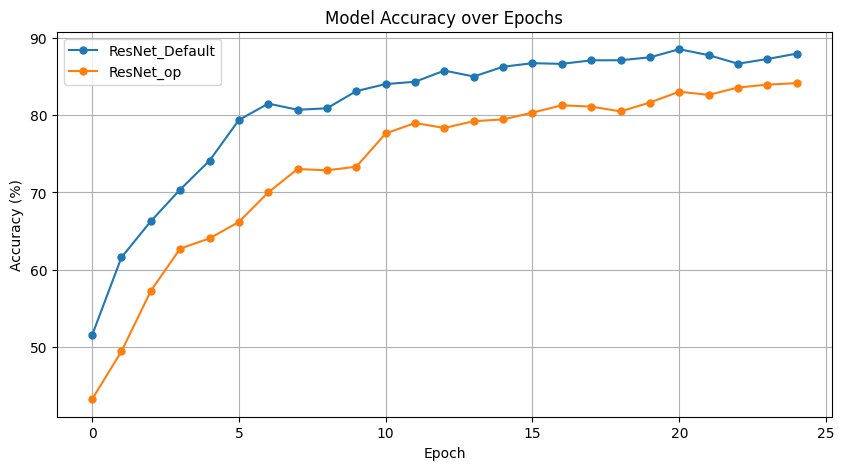

In [22]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='ResNet_op')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

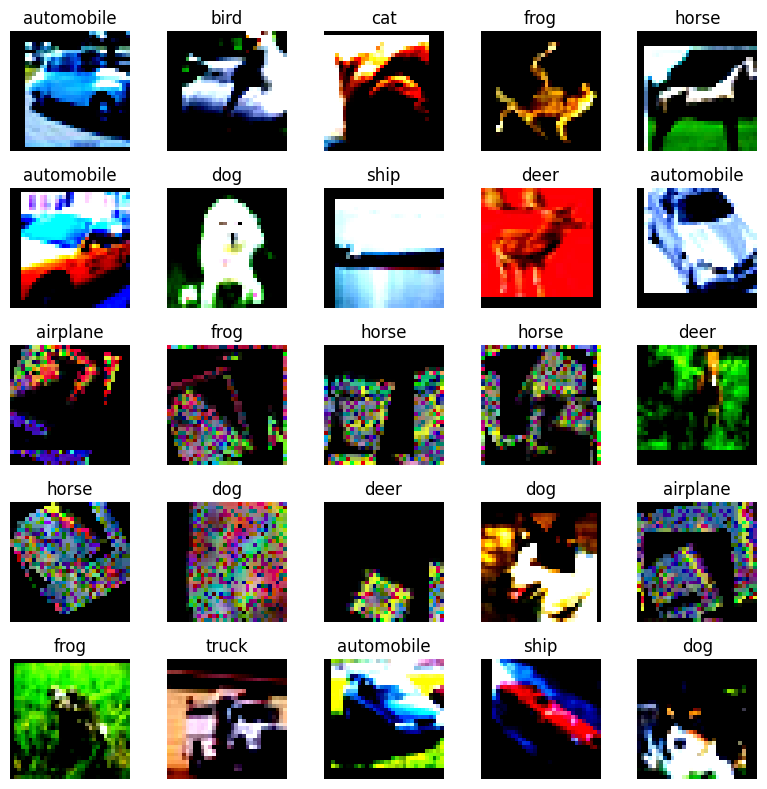

In [23]:
visualize_multiple_dataloaders([train_loader, train_loader_attacked, train_loader_attacked, train_loader_attacked, train_loader_attacked], test_loader, images_per_loader=5)

#### Poison Activation Validator

In [24]:
train_set_attacked_validate = load_dataset(folder_path = default_path, dat_name = "poisoned_validate.dat")
if train_set_attacked_validate== None or Data_Reset == True or poision_sys_reset == True:
    train_set_attacked_validate = AugmentedDataset(
        dataset=train_set,
        perterbationset=add_set,
        attacked_ratio=1,
        overlay=True,
        alpha=0.5,
        label_attack=True,
        partial_overlay=True,
        corruption_ratio=0.2,
        attack_order="label",
        im_proc_order="overlay"
    )
    save_dataset(train_set_attacked_validate, dat_name = "poisoned_validate.dat")

train_loader_attacked_validate = DataLoader(dataset=train_set_attacked_validate, batch_size=64, shuffle=True)

del train_loader_attacked_validate
del train_set_attacked_validate

데이터 없음
data saved


### 6. Image Restoration Module

#### 6.1 중독데이터 복원 AI 학습

##### CIFAR-10을 학습데이터로 이용

In [25]:
auto_10 = Autoencoder().to(device)
unet_10 = UNet().to(device)

Autotest = train_model(auto_10, train_loader, net_reset= restore_sys_reset, net_name="auto_10.pt", log_name = "auto_10")
unettest = train_model(unet_10, train_loader, net_reset= restore_sys_reset, net_name="unet_10.pt", log_name = "unet_10")

Number of Data Type: 2
Epoch [1/25], Loss: 0.7515381345968417
Epoch [2/25], Loss: 0.5674718094375127
Epoch [3/25], Loss: 0.522787566799337
Epoch [4/25], Loss: 0.5004676345669096
Epoch [5/25], Loss: 0.4880029512640765
Epoch [6/25], Loss: 0.4774501720429077
Epoch [7/25], Loss: 0.46756277463930035
Epoch [8/25], Loss: 0.45914670230482546
Epoch [9/25], Loss: 0.4544749985189389
Epoch [10/25], Loss: 0.4495987233984501
Epoch [11/25], Loss: 0.4454449741812923
Epoch [12/25], Loss: 0.44241228181382886
Epoch [13/25], Loss: 0.4393467477063084
Epoch [14/25], Loss: 0.4360398337283098
Epoch [15/25], Loss: 0.43333088635178785
Epoch [16/25], Loss: 0.4302650193881501
Epoch [17/25], Loss: 0.42819210361031923
Epoch [18/25], Loss: 0.4259966533354786
Epoch [19/25], Loss: 0.4253467409430867
Epoch [20/25], Loss: 0.4231870019298685
Epoch [21/25], Loss: 0.4216150117042424
Epoch [22/25], Loss: 0.4201284210242884
Epoch [23/25], Loss: 0.4182941252770631
Epoch [24/25], Loss: 0.41641151337215054
Epoch [25/25], Loss: 

##### 중독데이터를 학습데이터로 이용

In [26]:
auto_attacked = Autoencoder().to(device)
unet_attacked = UNet().to(device)

Autotest_attaked = train_model(auto_attacked, train_loader_attacked, net_reset= restore_sys_reset, net_name="auto_attacked.pt", log_name = "auto_attacked")
unettest_attaked = train_model(unet_attacked, train_loader_attacked, net_reset= restore_sys_reset, net_name="unet_attacked.pt", log_name = "unet_attacked")

Number of Data Type: 4
Epoch [1/25], Loss: 0.4796649488189336
Epoch [2/25], Loss: 0.3763586117331024
Epoch [3/25], Loss: 0.34635084006182676
Epoch [4/25], Loss: 0.3334153936723309
Epoch [5/25], Loss: 0.32418559792706425
Epoch [6/25], Loss: 0.3169603617409306
Epoch [7/25], Loss: 0.31185599365045347
Epoch [8/25], Loss: 0.30797844446833483
Epoch [9/25], Loss: 0.3036686783213445
Epoch [10/25], Loss: 0.2999035723678901
Epoch [11/25], Loss: 0.2968504014794174
Epoch [12/25], Loss: 0.29471068316713317
Epoch [13/25], Loss: 0.29203558842773025
Epoch [14/25], Loss: 0.2896674437176846
Epoch [15/25], Loss: 0.28850963656478523
Epoch [16/25], Loss: 0.28606739689779404
Epoch [17/25], Loss: 0.2842587520704245
Epoch [18/25], Loss: 0.283354086606094
Epoch [19/25], Loss: 0.28204045749610035
Epoch [20/25], Loss: 0.2802811978989855
Epoch [21/25], Loss: 0.278359044771975
Epoch [22/25], Loss: 0.27721038756087
Epoch [23/25], Loss: 0.27623301159466623
Epoch [24/25], Loss: 0.27578646464802115
Epoch [25/25], Loss

##### CIFAR-100을 학습데이터로 이용

In [27]:
auto_100 = Autoencoder().to(device)
unet_100 = UNet().to(device)

Autotest_100 = train_model(auto_100, add_loader, net_reset= restore_sys_reset, net_name="auto_100.pt", log_name = "auto_100")
unettest_100 = train_model(unet_100, add_loader, net_reset= restore_sys_reset, net_name="unet_100.pt", log_name = "unet_100")

Number of Data Type: 2
Epoch [1/25], Loss: 0.7565968029791742
Epoch [2/25], Loss: 0.5835103489401395
Epoch [3/25], Loss: 0.5507321860784155
Epoch [4/25], Loss: 0.5321515840490151
Epoch [5/25], Loss: 0.5186456806595673
Epoch [6/25], Loss: 0.5077043718770337
Epoch [7/25], Loss: 0.4994398711053917
Epoch [8/25], Loss: 0.49323131567072076
Epoch [9/25], Loss: 0.48846937285359865
Epoch [10/25], Loss: 0.48295648830473575
Epoch [11/25], Loss: 0.4798320922476556
Epoch [12/25], Loss: 0.4760013935739732
Epoch [13/25], Loss: 0.4729421615524365
Epoch [14/25], Loss: 0.4701446578325823
Epoch [15/25], Loss: 0.46781078937565884
Epoch [16/25], Loss: 0.4662104982625493
Epoch [17/25], Loss: 0.46432696126611034
Epoch [18/25], Loss: 0.46226180114252186
Epoch [19/25], Loss: 0.4606037633040982
Epoch [20/25], Loss: 0.4591220508298606
Epoch [21/25], Loss: 0.4590685698382385
Epoch [22/25], Loss: 0.45597776686748887
Epoch [23/25], Loss: 0.4545965367723304
Epoch [24/25], Loss: 0.4536647253557849
Epoch [25/25], Loss

#### 6.2 학습결과 표출

In [28]:
# 이미지 결과 확인 함수
def show_images(restored_data, index = 0):
    # 결과 이미지를 시각화
    if isinstance(restored_data, restored_Items):
        o_image, o_label, p_image, p_label, r_cond, r_image = restored_data.original_images, restored_data.original_labels, restored_data.poisoned_images, restored_data.poisoned_labels, restored_data.condition_code, restored_data.restored_images
    else :
        o_image, o_label, p_image, p_label, r_image = restored_data.original_images, restored_data.original_labels, restored_data.poisoned_images, restored_data.poisoned_labels, restored_data.restored_images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    ax[0].imshow(o_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[0].set_title('Original')
    ax[1].imshow(p_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[1].set_title('Poisoned')
    ax[2].imshow(r_image[index].permute(1, 2, 0).cpu().detach().numpy())
    ax[2].set_title('Recovered Output')
    
    plt.show()
    print("Original Label:", o_label[index])
    print("Poisoned Label:", p_label[index])
    if isinstance(restored_data, restored_Items):
        print("Poisoned condition:", r_cond[index])
    del restored_data
    torch.cuda.empty_cache()
    gc.collect()

def multi_show(restored_data, sample = 10):
    for i in range(sample):
        label = restored_data.poisoned_labels
        index = random.randrange(1, len(label))
        show_images(restored_data, index)
    del restored_data
    torch.cuda.empty_cache()
    gc.collect()

#### 6.3 중독 데이터 분류

##### 블러감지

In [29]:
def blur_IO(image_in, threshold=0.5):
    # 이미지 읽기
    image_b = image_in.cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

    # PyTorch는 RGB 순서이므로 BGR로 변환해야 함
    image_b = cv2.cvtColor(image_b, cv2.COLOR_RGB2BGR)
    
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)
    
    # Laplacian을 사용하여 이미지의 엣지 강도를 계산
    variance = cv2.Laplacian(gray_image, cv2.CV_32F).var()
    
    # 분산 값이 낮으면 블러링이 발생한 것으로 판단
    if variance < threshold:
        return True  # 이미지가 블러됨
    else:
        return False  # 이미지가 선명함


##### 노이즈 감지

In [30]:
def noise_IO(image_in, threshold=5.0):
    # 이미지 읽기
    image_n = image_in.cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # PyTorch는 RGB 순서이므로 BGR로 변환해야 함
    image_n = cv2.cvtColor(image_n, cv2.COLOR_RGB2BGR)
    
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image_n, cv2.COLOR_BGR2GRAY)
    
    # 이미지의 표준 편차를 계산
    std_dev = np.std(gray_image)
    
    # 표준 편차가 일정 값 이상이면 노이즈가 있다고 판단
    if std_dev > threshold:
        return True  # 이미지에 노이즈가 있음
    else:
        return False  # 이미지에 노이즈 없음


##### 변형감지

In [31]:
def c_distortion_IO(image_in, threshold=140):                ##Colour Distortion
    # 이미지 읽기
    image_d = image_in.cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    # PyTorch는 RGB 순서이므로 BGR로 변환해야 함
    image_d = cv2.cvtColor(image_d, cv2.COLOR_RGB2BGR)
    
    # 이미지를 BGR에서 HSV로 변환
    hsv_image = cv2.cvtColor(image_d, cv2.COLOR_BGR2HSV)
    
    # HSV 채널 분리
    h, s, v = cv2.split(hsv_image)
    
    # 색상의 평균값과 표준 편차 계산
    mean_hue = np.mean(h)
    mean_saturation = np.mean(s)
    mean_value = np.mean(v)
    
    # 왜곡이 있을 경우 평균값이 비정상적으로 클 수 있음
    if mean_hue > threshold or mean_saturation > threshold or mean_value > threshold:
        return True  # 색 왜곡 있음
    else:
        return False  # 색 왜곡 없음


#### 6.4 중독된 데이터 복구 적용

#### 복구데이터 클래스 정의

In [32]:
class CIFAR10WithModelOutputAndLabels(Dataset):
    def __init__(self, original_images, original_labels, poisoned_images,  poisoned_labels, restored_images):
        self.original_images= original_images
        self.original_labels = original_labels        
        self.poisoned_images = poisoned_images
        self.poisoned_labels = poisoned_labels
        self.restored_images = restored_images

    def __len__(self):
        return len(self.poisoned_images)

    def __getitem__(self, idx):
        return self.original_images[idx], self.original_labels[idx], self.poisoned_images[idx], self.poisoned_labels[idx] , self.restored_images[idx]

# 이미지를 모델에 통과시키고 출력 저장하는 함수
def process_and_save_cifar10(dataloader, net_name ="default_net.pt" , output_filename="processed_cifar10_with_labels.pth"):
    """
    CIFAR-10 DataLoader에서 이미지를 처리하고, 모델의 출력과 라벨을 저장하는 함수.
    """
    os.chdir(default_path)
    if (os.path.exists(output_filename) == False and Auto_Init == True) or Data_Reset == True:
        model = torch.load(net_name)
        model.eval()  # 모델을 평가 모드로 설정
        os.chdir("../")

        all_original_images =[]
        all_original_labels=[]
        all_images = []
        all_outputs = []
        all_labels = []

        with torch.no_grad():  # 예측 시에는 그래디언트 계산을 하지 않음
            for data in dataloader:
                original_images, original_labels, images, labels = data
                # 이미지를 GPU로 이동 (GPU가 사용 가능하면)
                images = images.cuda() if torch.cuda.is_available() else images
                labels = labels.cuda() if torch.cuda.is_available() else labels

                # 모델을 통해 예측 결과 얻기
                outputs = model(images)

                # 결과를 리스트에 추가
                all_original_images.append(original_images)
                all_original_labels.append(original_labels)
                all_images.append(images.cpu())  # CPU로 이동하여 저장
                all_labels.append(labels.cpu())  # CPU로 이동하여 저장
                all_outputs.append(outputs.cpu())  # CPU로 이동하여 저장

        # CIFAR-10 이미지, 모델 출력, 라벨을 포함한 Dataset 생성
        combined_dataset = CIFAR10WithModelOutputAndLabels(
            torch.cat(all_original_images), torch.cat(all_original_labels), torch.cat(all_images), torch.cat(all_labels) , torch.cat(all_outputs)
        )

        os.chdir(default_path)
        # PyTorch Dataset을 저장
        torch.save(combined_dataset, output_filename)
        print(f"Processed data with labels saved to {output_filename}")
        
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    elif Auto_Init == False:
        print("학습을 생략")
    else :
        print("학습된 파일이 있습니다")
    print(os.getcwd)
    os.chdir("../")



In [33]:
class restored_Items(Dataset):
    " Restoration_Condition 추가"
    def __init__(self, original_images, original_labels, poisoned_images,  poisoned_labels, condition_code, restored_images):
        self.original_images= original_images
        self.original_labels = original_labels        
        self.poisoned_images = poisoned_images
        self.poisoned_labels = poisoned_labels
        self.condition_code = condition_code                ## 0: non poisoned, 1: blur, 2: noise, 4:destortion = condition
        self.restored_images = restored_images 

    def __len__(self):
        return len(self.poisoned_images)

    def __getitem__(self, idx):
        return self.original_images[idx], self.original_labels[idx], self.poisoned_images[idx], self.poisoned_labels[idx], self.condition_code[idx], self.restored_images[idx]
    
    def _code_(self, idx):
        if self.condition_code == 0 :
            code_name = " - "
        else : 
            code_name = "에러" + str(self.condition_code)
        return code_name

# 이미지를 모델에 통과시키고 출력 저장하는 함수
def restore(dataloader, restore_reset_IO = reclass_sys_reset, net_name ="default_net.pt" , output_filename="processed_cifar10_with_labels.pth"):
    """
    CIFAR-10 DataLoader에서 이미지를 처리하고, 모델의 출력과 라벨을 저장하는 함수.
    """
    os.chdir(default_path)
    if (os.path.exists(output_filename) == False and Auto_Init == True) or Data_Reset == True or restore_reset_IO == True:
        model = torch.load(net_name)
        model.eval()  # 모델을 평가 모드로 설정
        os.chdir("../")

        all_original_images =[]
        all_original_labels=[]
        all_images = []
        all_outputs = []
        all_condition_code = []
        all_labels = []

        with torch.no_grad():  # 예측 시에는 그래디언트 계산을 하지 않음
            for data in dataloader:
                original_images, original_labels, images, labels = data               
                batch_condition_code = []

                for i in range(images.size(0)): 
                    condition_code = 0
                    if blur_IO(images[i]) == True:
                            condition_code = condition_code + 1
                    if noise_IO(images[i]) == True:
                            condition_code = condition_code + 2
                    if c_distortion_IO(images[i]) == True:
                            condition_code = condition_code + 4
                    batch_condition_code.append(condition_code)

                # 이미지를 GPU로 이동 (GPU가 사용 가능하면)
                images = images.cuda() if torch.cuda.is_available() else images
                labels = labels.cuda() if torch.cuda.is_available() else labels
                outputs = model(images)
                
                # 모델을 통해 예측 결과 얻기
                for i in range(images.size(0)):
                    if batch_condition_code[i] == 0:
                       outputs[i] = images[i] 


                # 결과를 리스트에 추가
                all_original_images.append(original_images)
                all_original_labels.append(original_labels)
                all_images.append(images.cpu())  # CPU로 이동하여 저장
                all_labels.append(labels.cpu())  # CPU로 이동하여 저장
                all_condition_code.append(torch.tensor(batch_condition_code))
                all_outputs.append(outputs.cpu())  # CPU로 이동하여 저장
                

        # CIFAR-10 이미지, 모델 출력, 라벨을 포함한 Dataset 생성
        combined_dataset = restored_Items(
            torch.cat(all_original_images), torch.cat(all_original_labels), torch.cat(all_images), torch.cat(all_labels), torch.cat(all_condition_code), torch.cat(all_outputs)
        )

        os.chdir(default_path)
        # PyTorch Dataset을 저장
        torch.save(combined_dataset, output_filename)
        print(f"Processed data with labels saved to {output_filename}")
        
        del model
        torch.cuda.empty_cache()
        gc.collect()
    
    elif Auto_Init == False:
        print("학습을 생략")
    else :
        print("학습된 파일이 있습니다")
    print(os.getcwd)
    os.chdir("../")



#### 복구

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to auto_10.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1474868064.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_10 = torch.load("auto_10.pth")
Clipping input data t

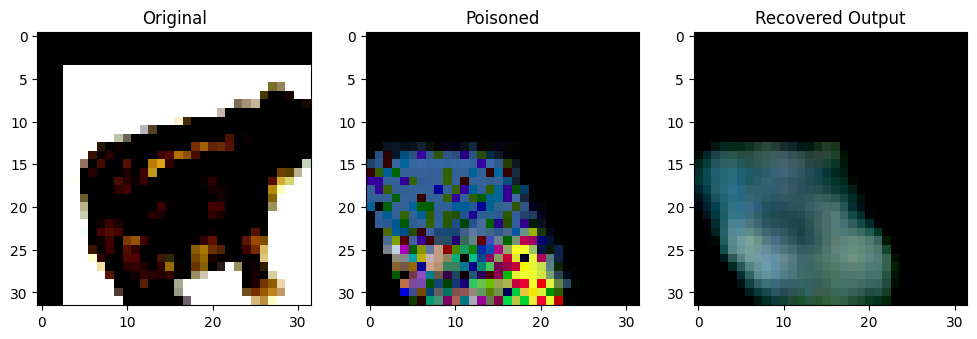

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1804092].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995858].


Original Label: tensor(6)
Poisoned Label: tensor(7)
Poisoned condition: tensor(1)


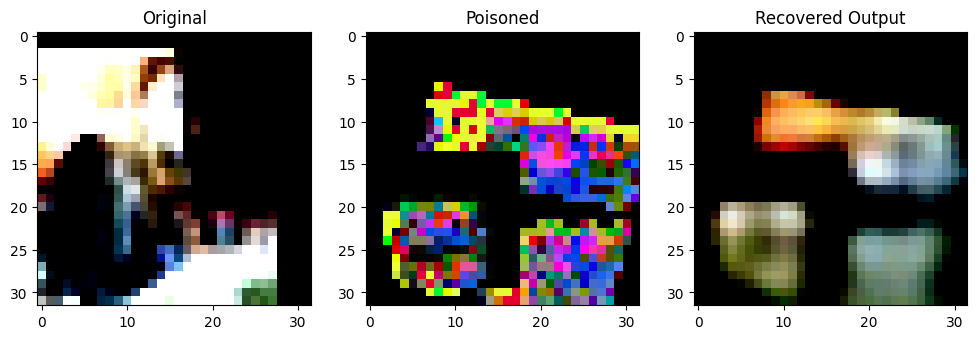

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(3)
Poisoned Label: tensor(4)
Poisoned condition: tensor(1)


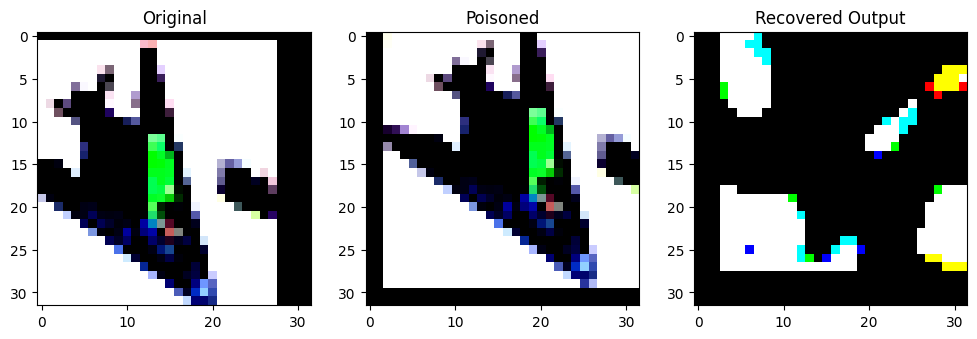

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2146587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.80398315].


Original Label: tensor(0)
Poisoned Label: tensor(0)
Poisoned condition: tensor(4)


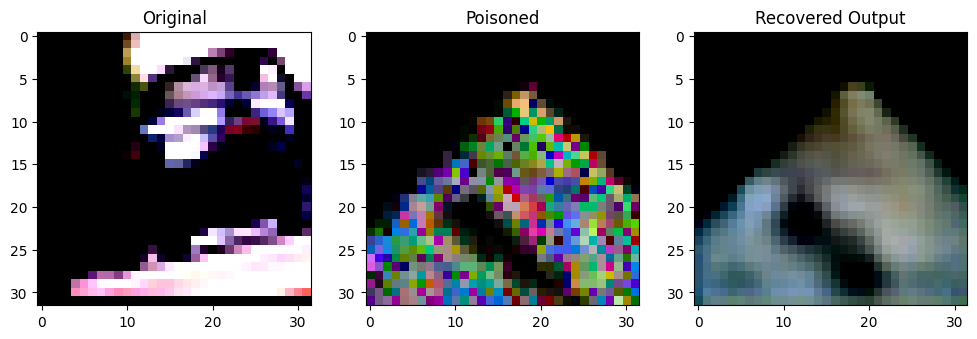

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79743683].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(1)


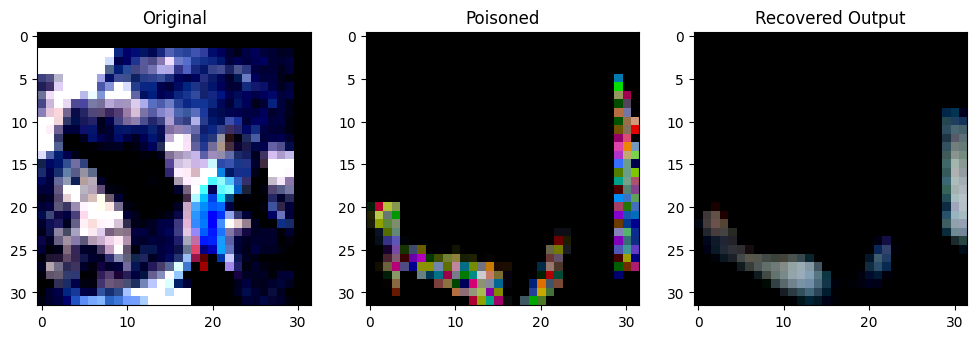

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0996952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(2)
Poisoned Label: tensor(4)
Poisoned condition: tensor(1)


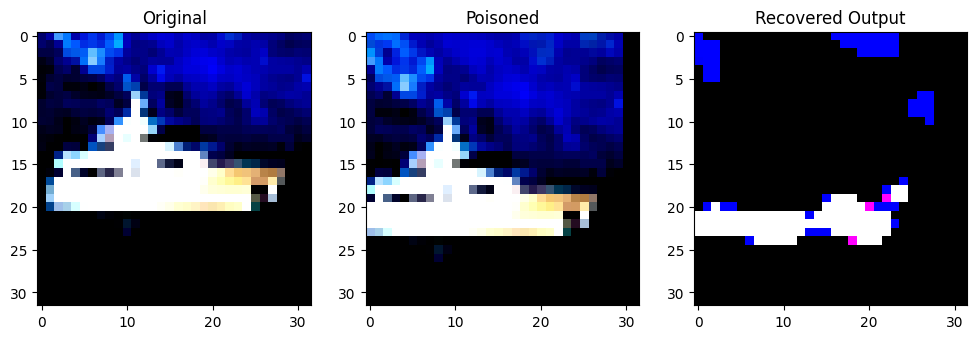

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9703693].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


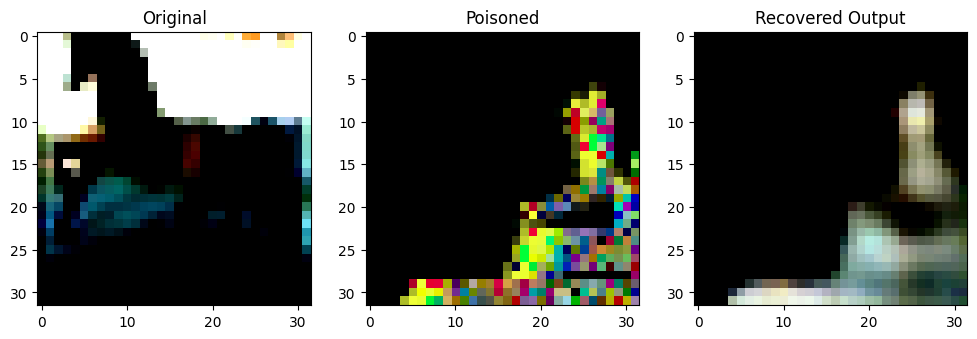

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5707283].


Original Label: tensor(7)
Poisoned Label: tensor(0)
Poisoned condition: tensor(1)


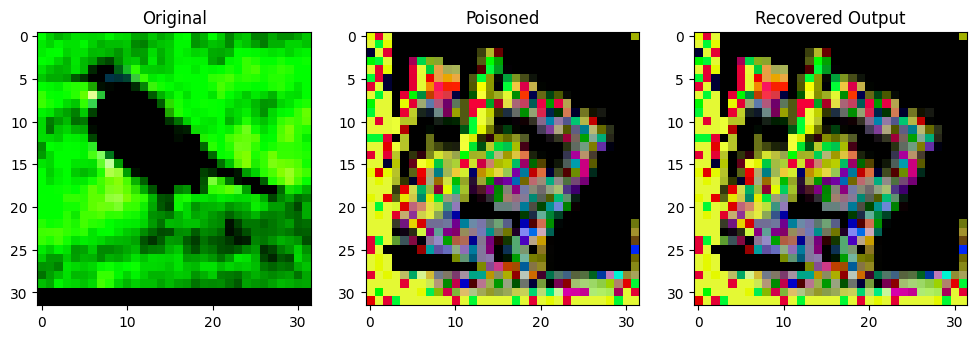

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(2)
Poisoned Label: tensor(8)
Poisoned condition: tensor(0)


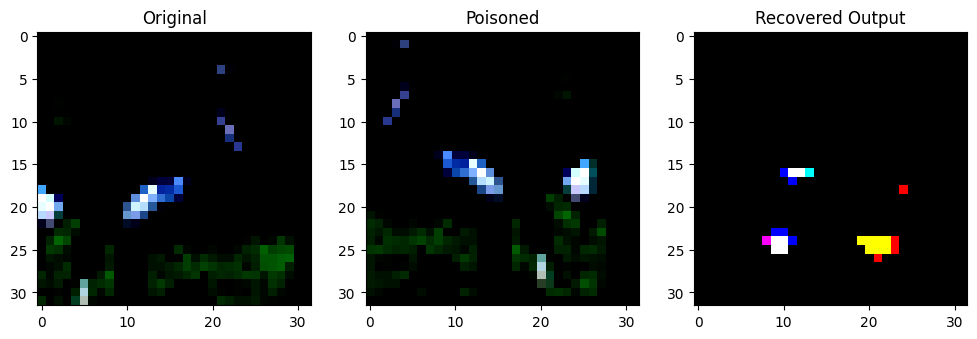

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(2)
Poisoned Label: tensor(2)
Poisoned condition: tensor(4)


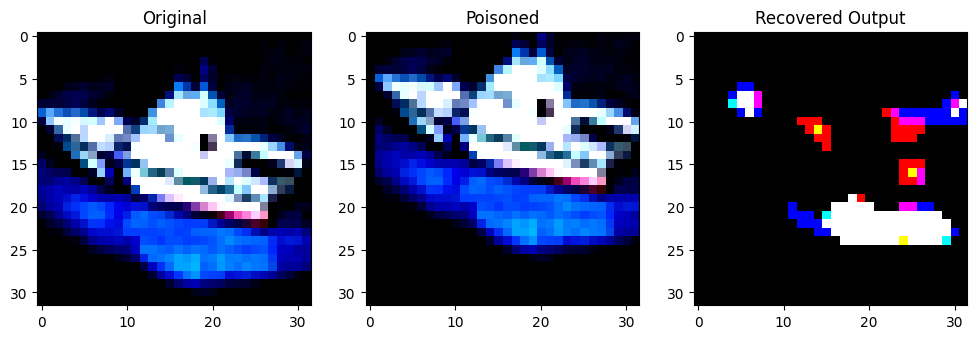

Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


0

In [34]:
# auto_10
if __name__ == "__main__":
    # CIFAR-10 DataLoader 로드

    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "auto_10.pt", output_filename="auto_10.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_10 = torch.load("auto_10.pth")
os.chdir("../")

# 데이터, 출력, 라벨 가져오기
multi_show(s_auto_10, sample = 10)

del s_auto_10
torch.cuda.empty_cache()
gc.collect()

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to unet_10.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\2491386991.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_10 = torch.load("unet_10.pth")
Clipping input data to

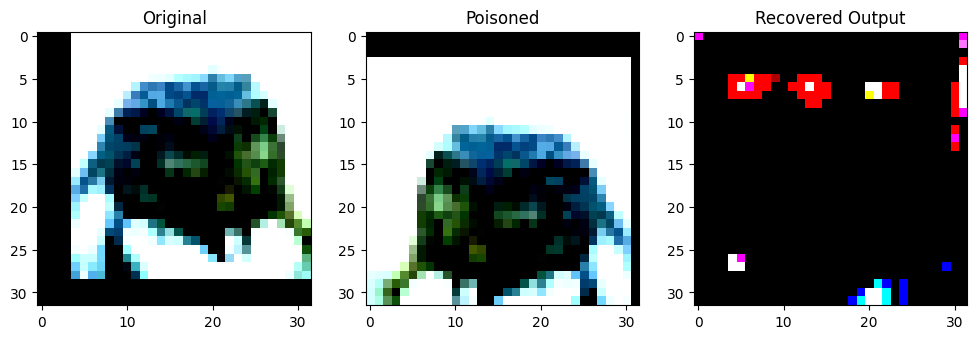

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1038.0099..527.19464].


Original Label: tensor(6)
Poisoned Label: tensor(6)
Poisoned condition: tensor(4)


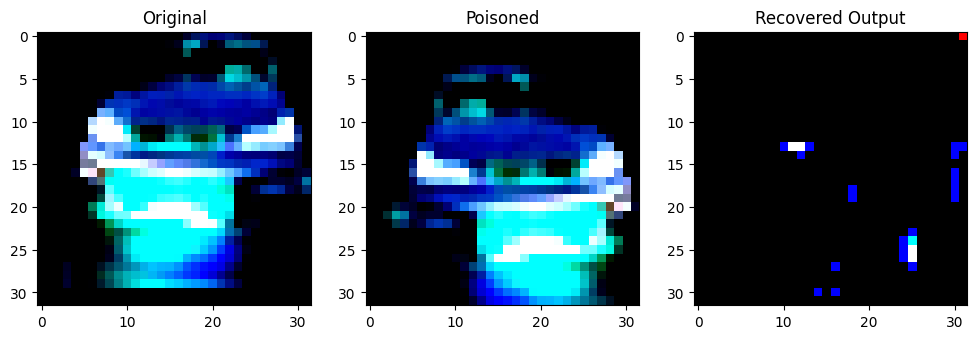

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2676191..0.93733394].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


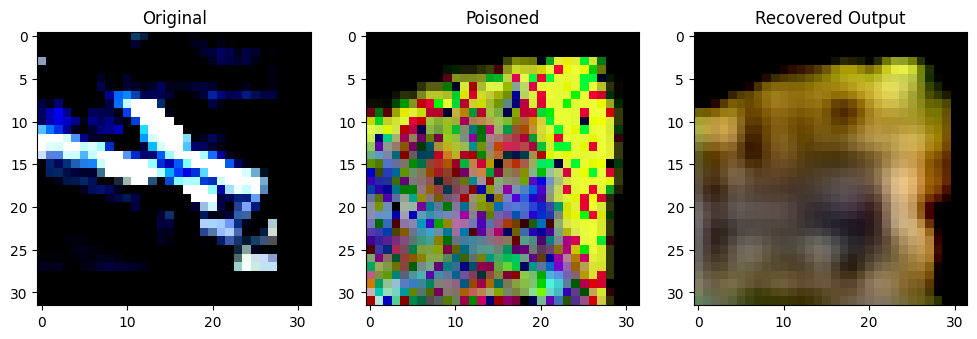

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.186841].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1518.0372..1418.8691].


Original Label: tensor(1)
Poisoned Label: tensor(7)
Poisoned condition: tensor(1)


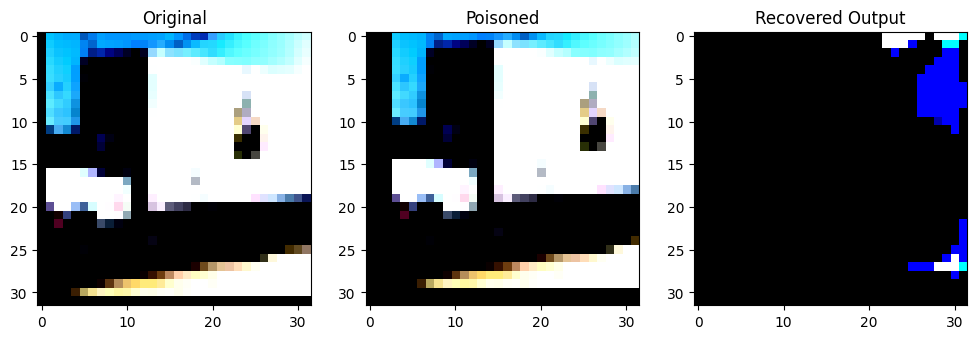

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-928.1725..517.74384].


Original Label: tensor(9)
Poisoned Label: tensor(9)
Poisoned condition: tensor(4)


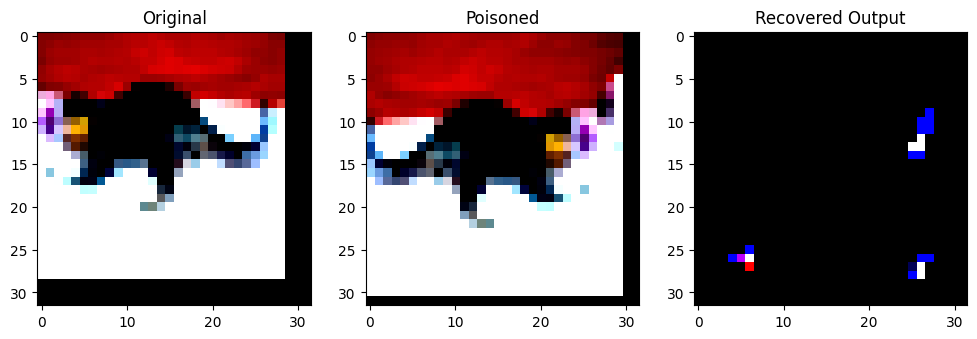

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.060536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0595045..0.8731478].


Original Label: tensor(3)
Poisoned Label: tensor(3)
Poisoned condition: tensor(4)


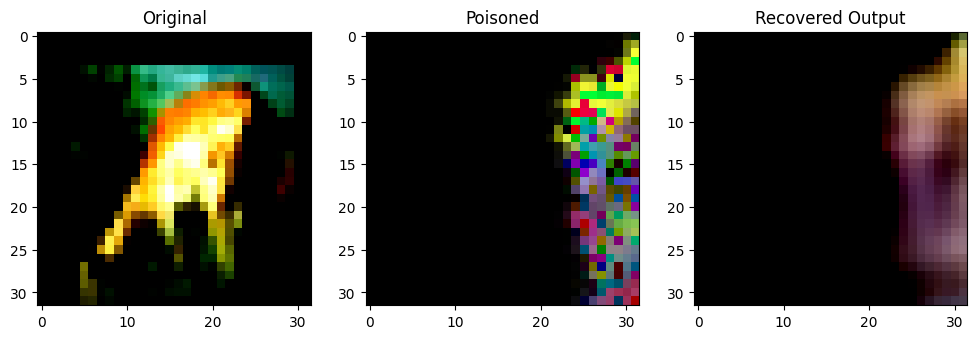

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-548.28436..833.1581].


Original Label: tensor(4)
Poisoned Label: tensor(0)
Poisoned condition: tensor(1)


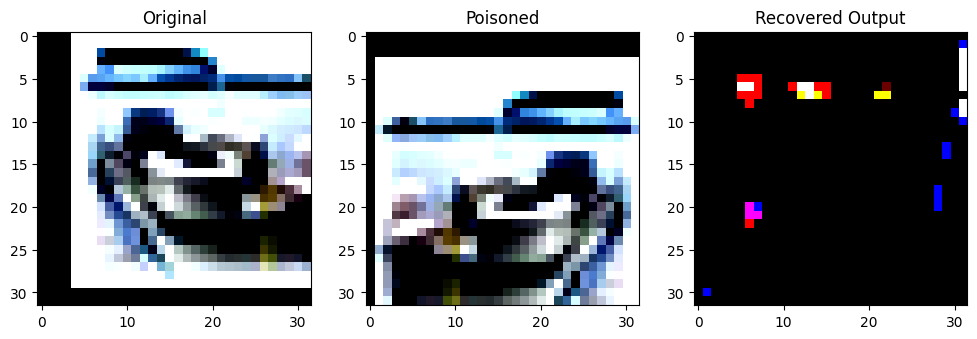

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0908954..0.6413359].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


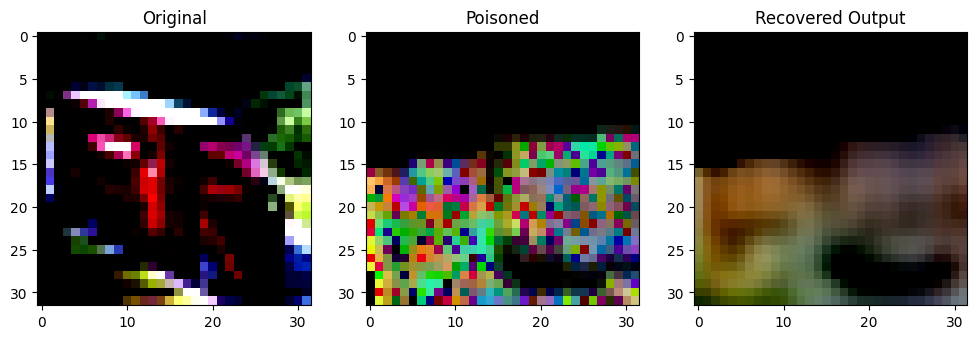

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8208281].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1015.1915..908.0287].


Original Label: tensor(9)
Poisoned Label: tensor(8)
Poisoned condition: tensor(1)


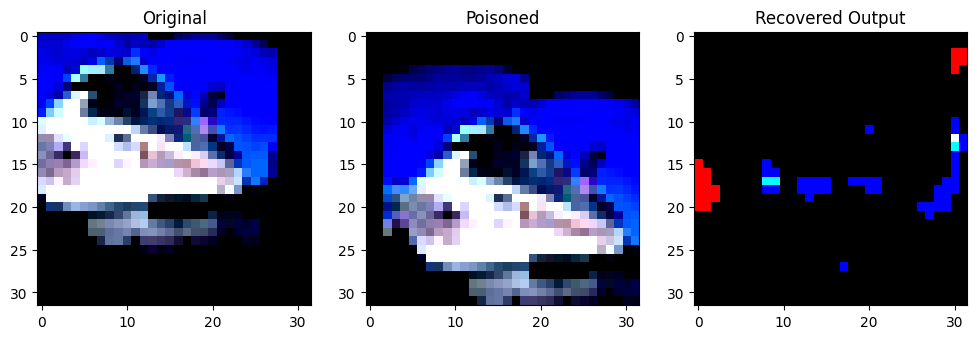

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


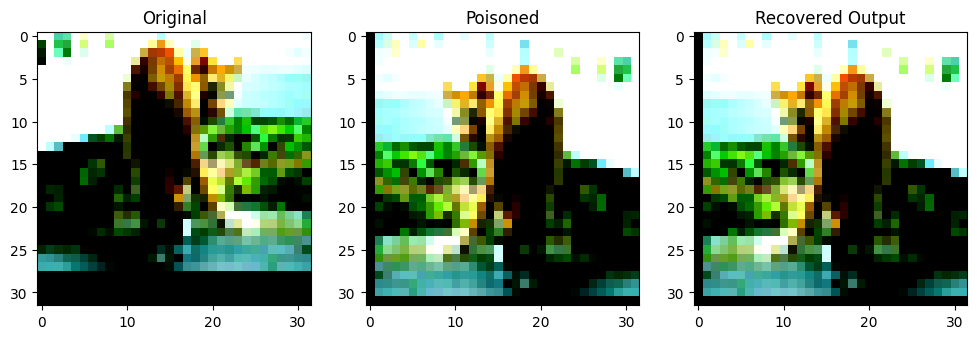

Original Label: tensor(3)
Poisoned Label: tensor(3)
Poisoned condition: tensor(0)


0

In [35]:
# unet_10
if __name__ == "__main__":
    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "unet_10.pt", output_filename="unet_10.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_10 = torch.load("unet_10.pth")
os.chdir("../")

multi_show(s_unet_10, sample = 10)

del s_unet_10
torch.cuda.empty_cache()
gc.collect()

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to auto_attacked.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\4245150385.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_attacked = torch.load("auto_attacked.pth")
Clipping i

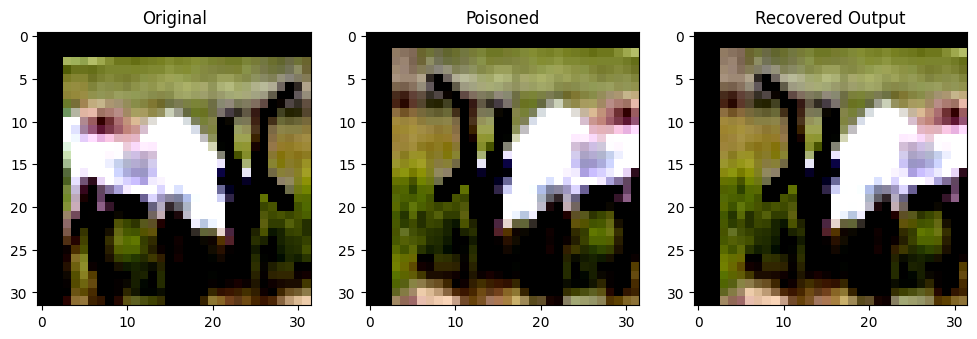

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(4)
Poisoned Label: tensor(4)
Poisoned condition: tensor(0)


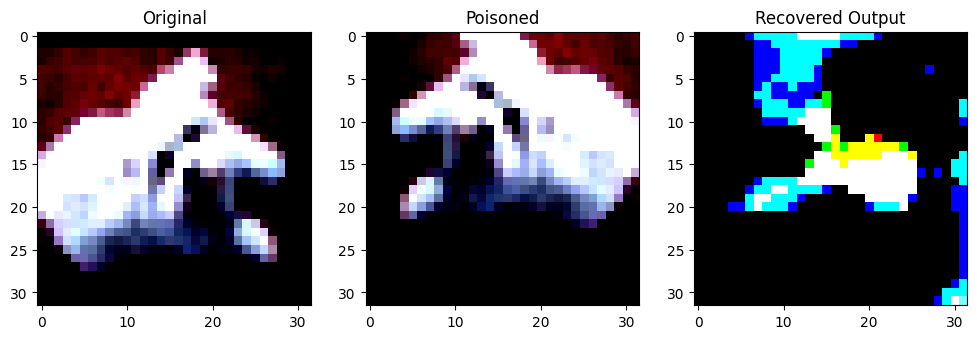

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9276795].


Original Label: tensor(5)
Poisoned Label: tensor(5)
Poisoned condition: tensor(4)


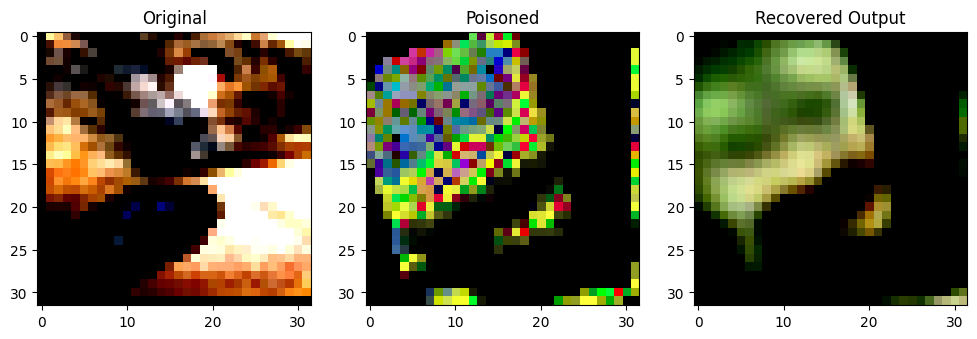

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(3)
Poisoned Label: tensor(3)
Poisoned condition: tensor(1)


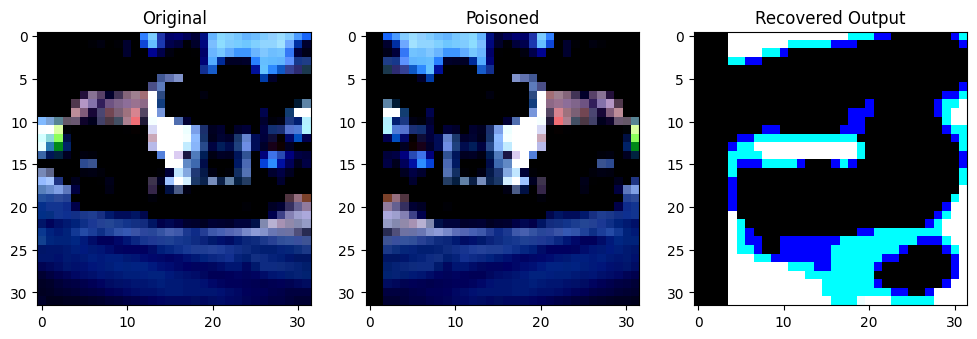

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9749122].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.87286776].


Original Label: tensor(9)
Poisoned Label: tensor(9)
Poisoned condition: tensor(4)


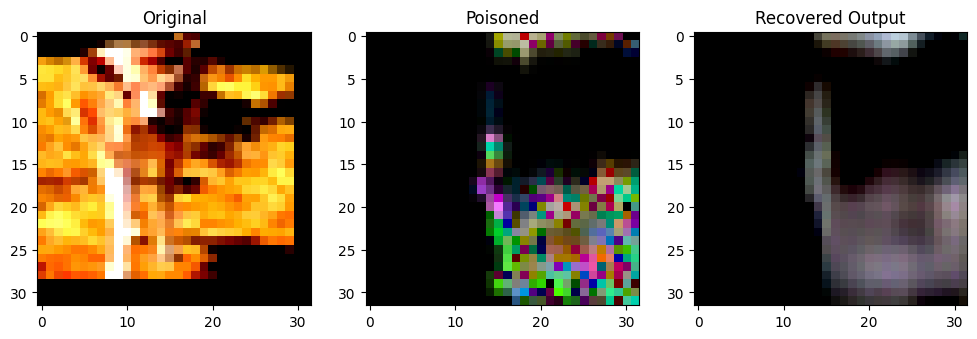

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7865399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7865399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(4)
Poisoned Label: tensor(3)
Poisoned condition: tensor(1)


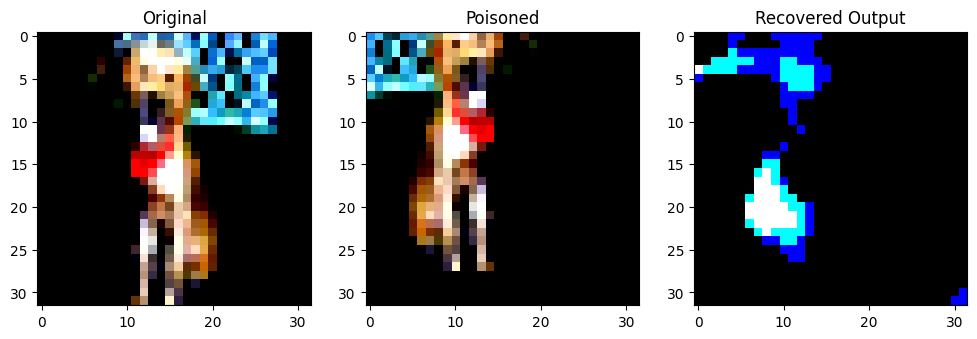

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(5)
Poisoned Label: tensor(5)
Poisoned condition: tensor(4)


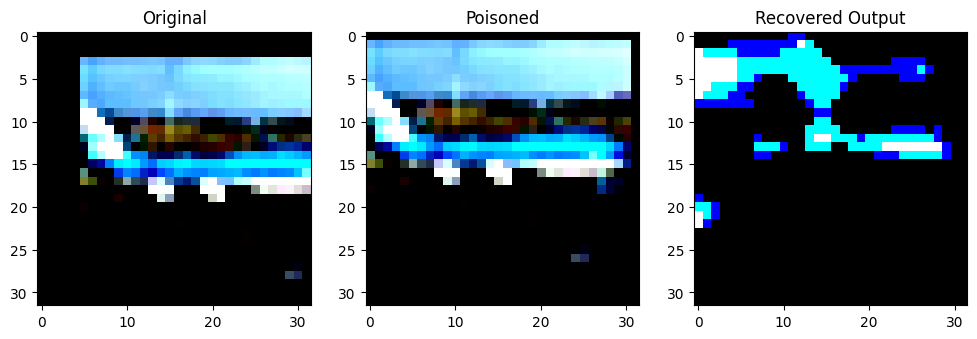

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(0)
Poisoned Label: tensor(0)
Poisoned condition: tensor(4)


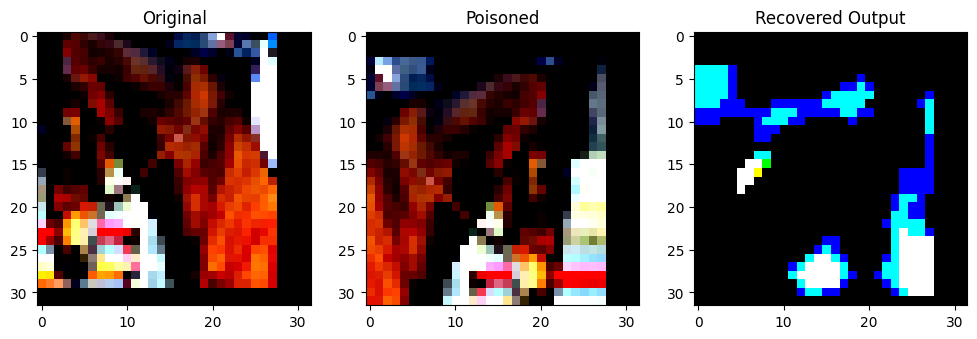

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(7)
Poisoned Label: tensor(7)
Poisoned condition: tensor(4)


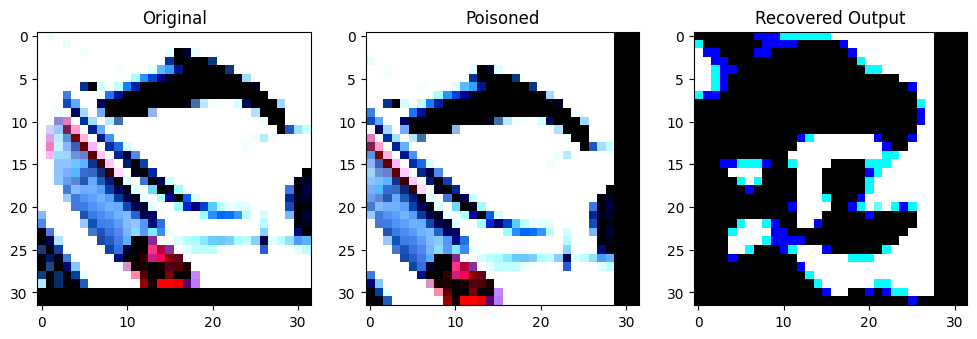

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


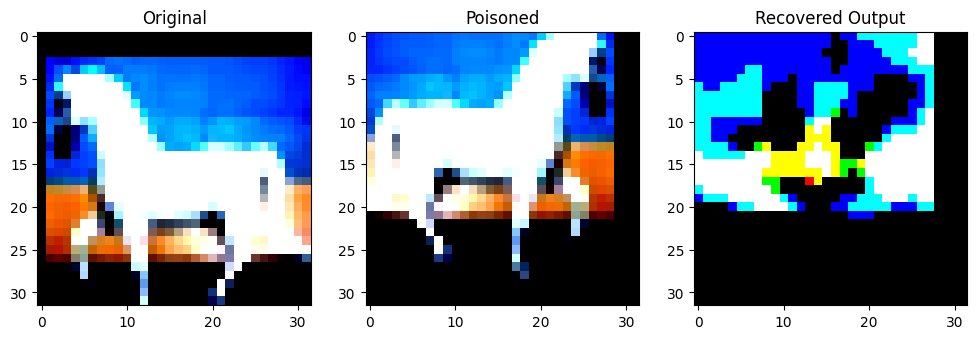

Original Label: tensor(7)
Poisoned Label: tensor(7)
Poisoned condition: tensor(4)


0

In [36]:
# auto_attack
if __name__ == "__main__":
    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "auto_attacked.pt", output_filename="auto_attacked.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_attacked = torch.load("auto_attacked.pth")
os.chdir("../")

multi_show(s_auto_attacked, sample = 10)

del s_auto_attacked
torch.cuda.empty_cache()
gc.collect()


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to unet_attacked.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\664180197.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_attacked = torch.load("unet_attacked.pth")
Clipping in

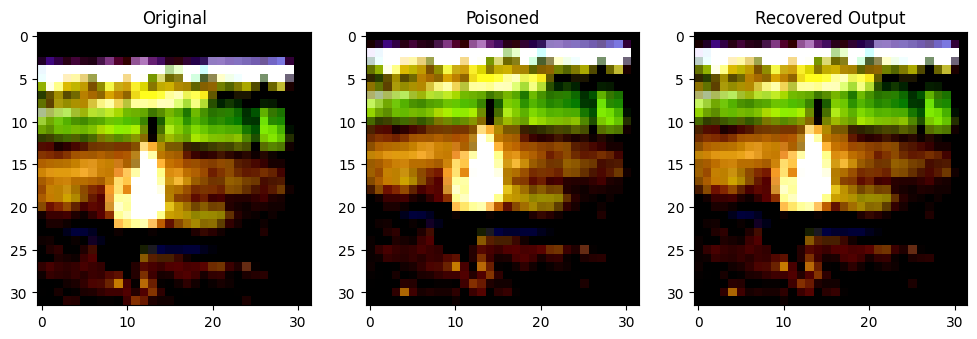

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-370.20032..223.00655].


Original Label: tensor(2)
Poisoned Label: tensor(2)
Poisoned condition: tensor(0)


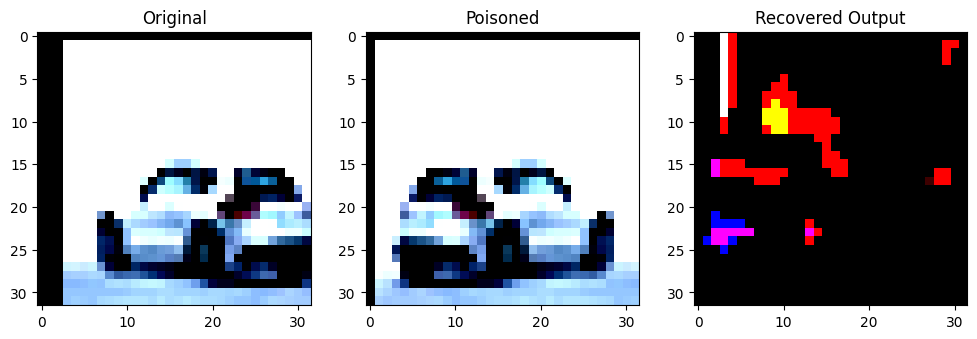

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4562583..1.0614332].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


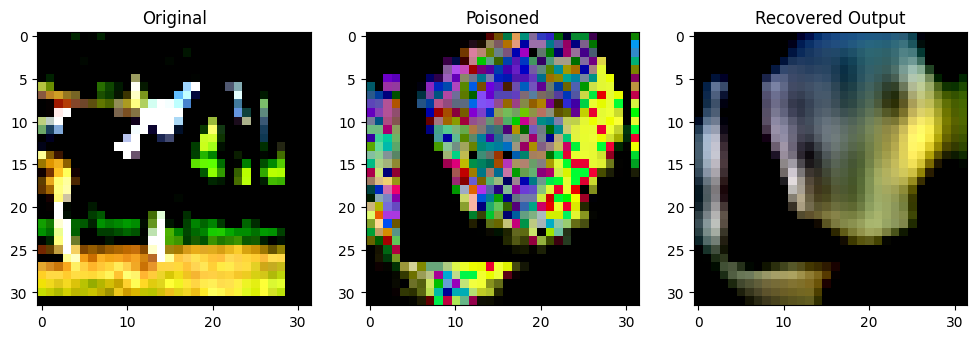

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7009162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9577874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-771.20886..803.31134].


Original Label: tensor(7)
Poisoned Label: tensor(3)
Poisoned condition: tensor(1)


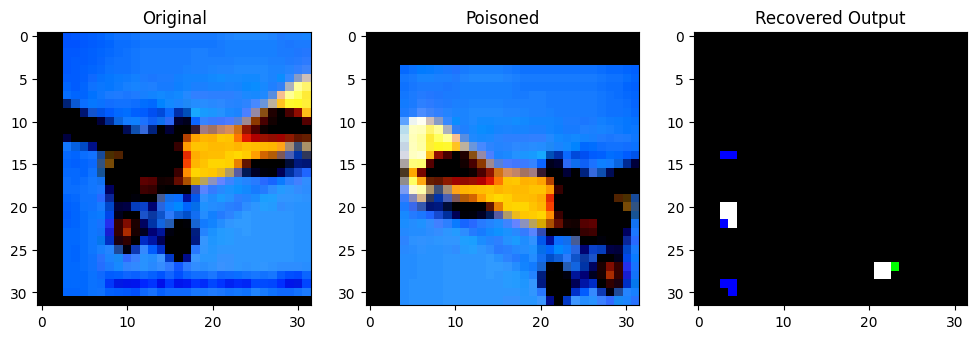

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original Label: tensor(0)
Poisoned Label: tensor(0)
Poisoned condition: tensor(4)


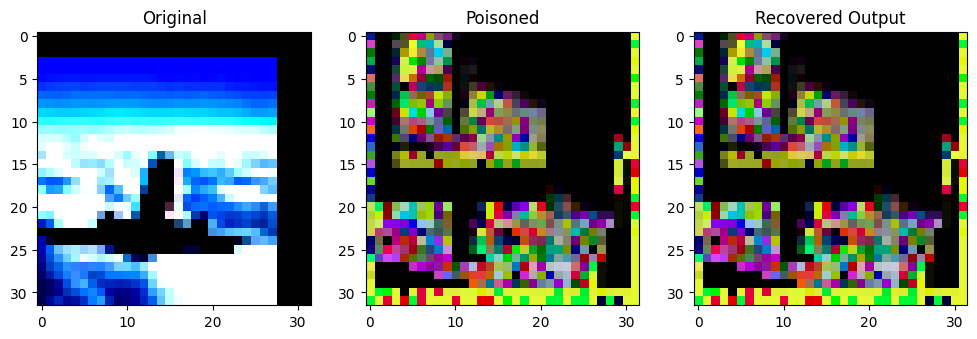

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.70535964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.70535964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1068.203..357.27444].


Original Label: tensor(0)
Poisoned Label: tensor(6)
Poisoned condition: tensor(0)


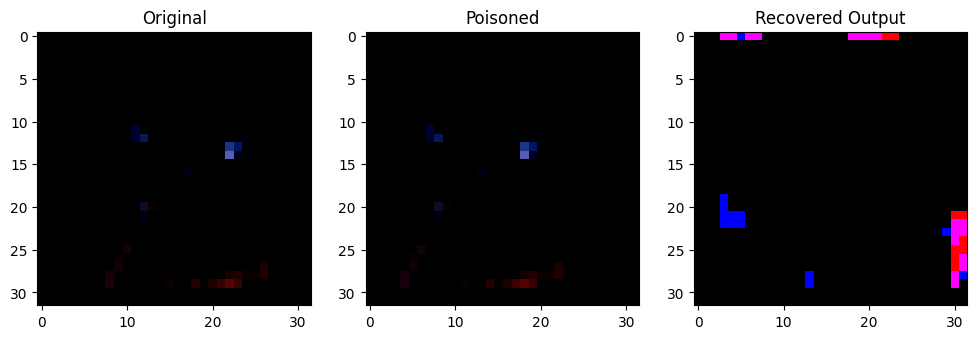

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3502399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1244.7546..549.31146].


Original Label: tensor(6)
Poisoned Label: tensor(6)
Poisoned condition: tensor(4)


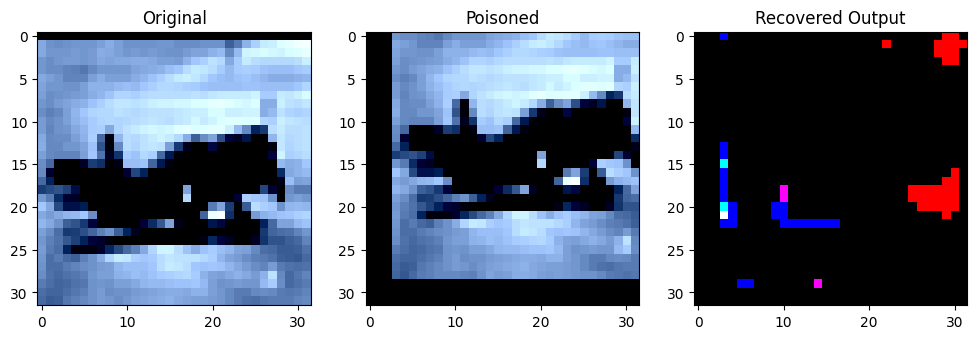

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1281.8074..695.7563].


Original Label: tensor(0)
Poisoned Label: tensor(0)
Poisoned condition: tensor(4)


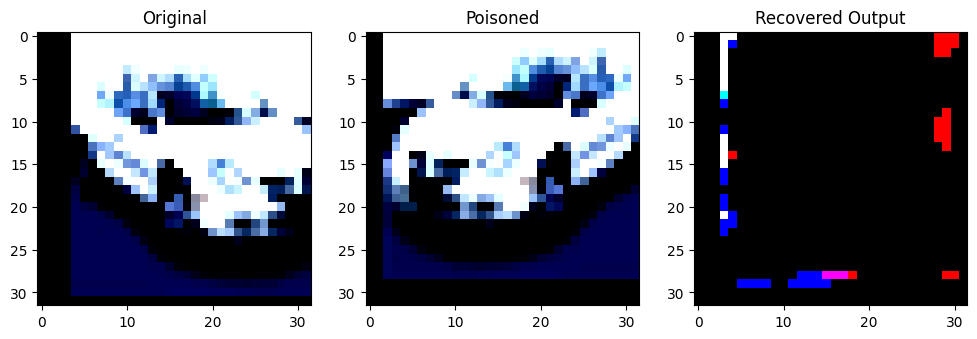

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0084033].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


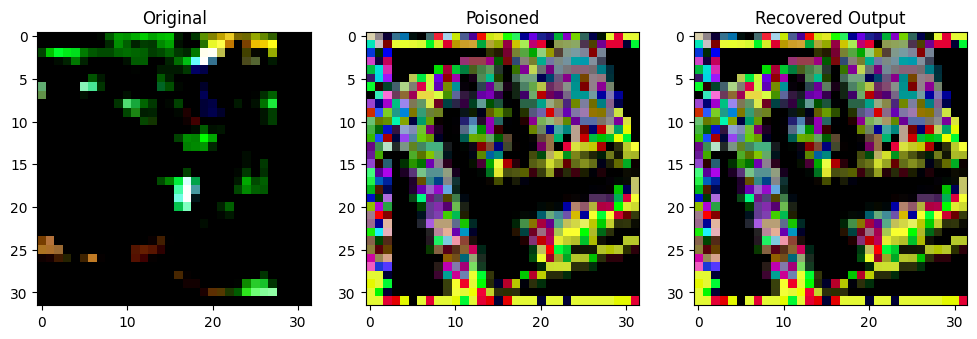

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0125492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.0125492].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1358.2325..418.86996].


Original Label: tensor(2)
Poisoned Label: tensor(3)
Poisoned condition: tensor(0)


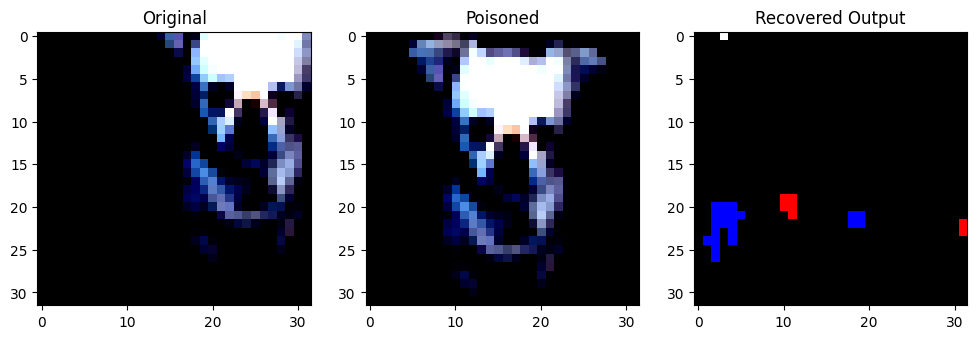

Original Label: tensor(5)
Poisoned Label: tensor(5)
Poisoned condition: tensor(4)


0

In [37]:
# unet_attack
if __name__ == "__main__":
    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "unet_attacked.pt", output_filename="unet_attacked.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_attacked = torch.load("unet_attacked.pth")
os.chdir("../")

multi_show(s_unet_attacked, sample = 10)

del s_unet_attacked
torch.cuda.empty_cache()
gc.collect()

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to auto_100.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\353969648.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_100 = torch.load("auto_100.pth")
Clipping input data t

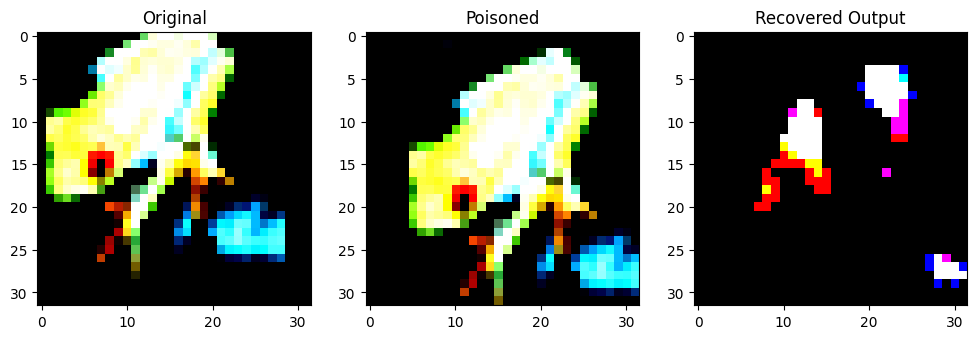

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(6)
Poisoned Label: tensor(6)
Poisoned condition: tensor(4)


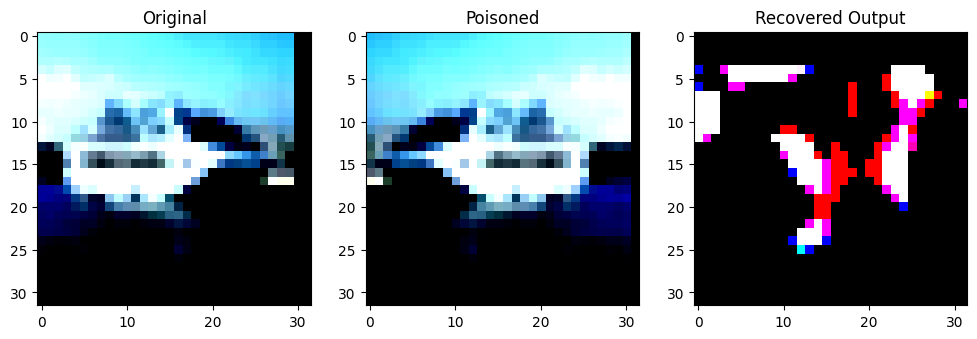

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2456646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


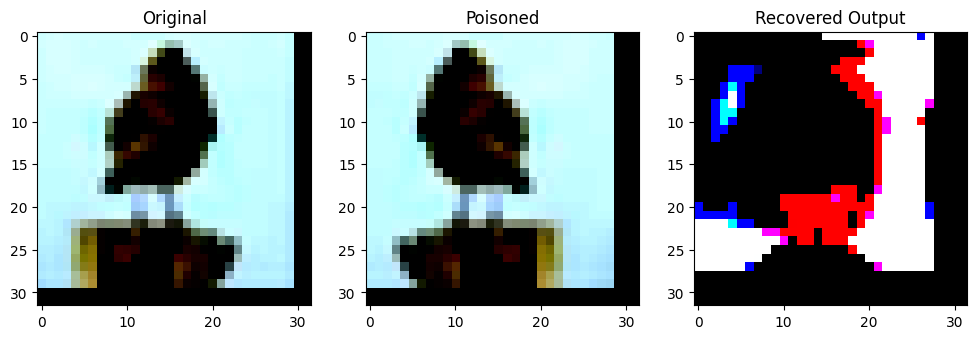

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85339016].


Original Label: tensor(2)
Poisoned Label: tensor(2)
Poisoned condition: tensor(4)


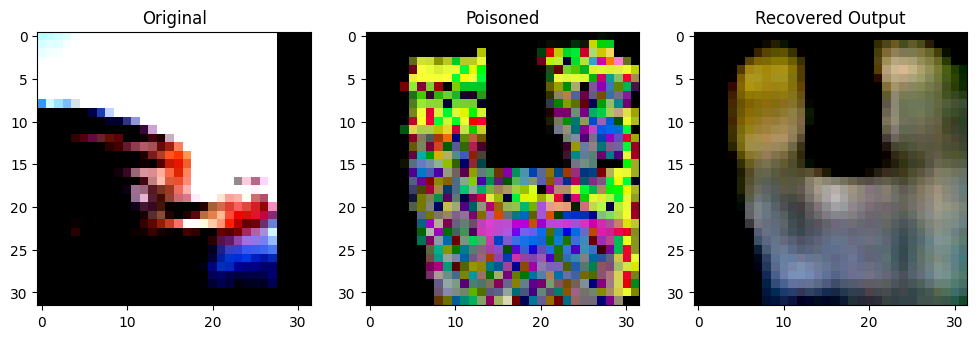

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3850982].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79897416].


Original Label: tensor(8)
Poisoned Label: tensor(2)
Poisoned condition: tensor(1)


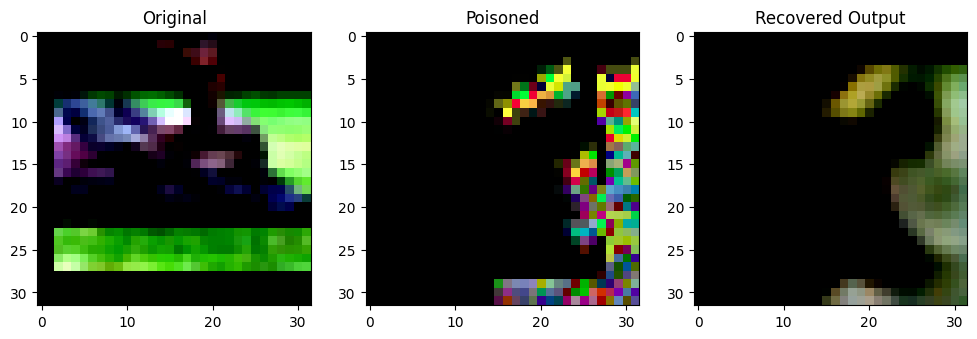

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(4)
Poisoned Label: tensor(9)
Poisoned condition: tensor(1)


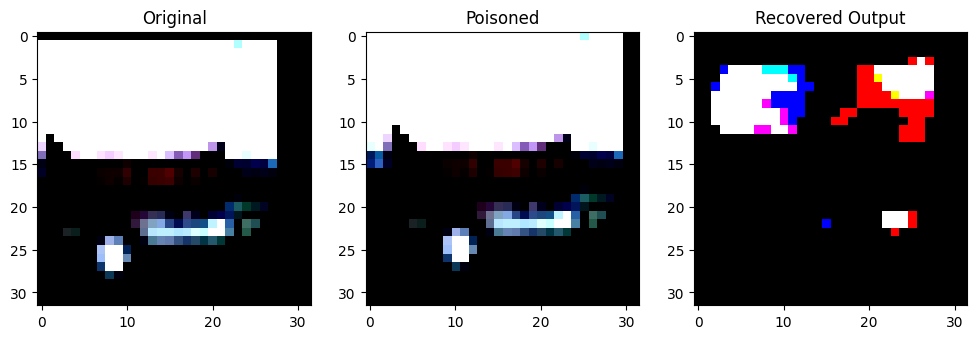

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7685405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9179286].


Original Label: tensor(9)
Poisoned Label: tensor(9)
Poisoned condition: tensor(4)


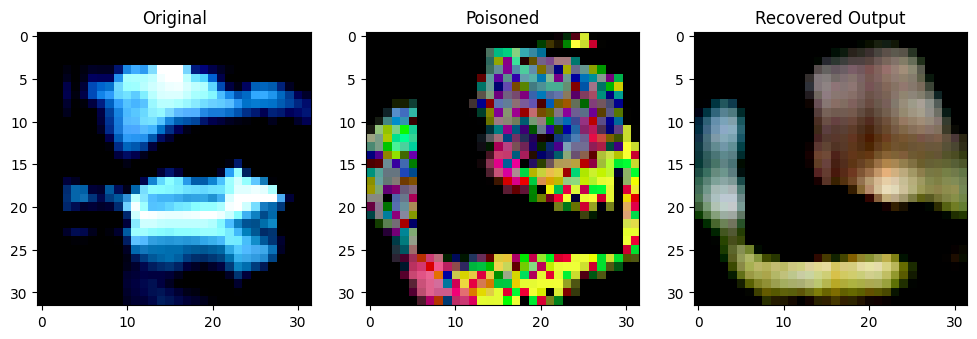

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6668999].


Original Label: tensor(8)
Poisoned Label: tensor(4)
Poisoned condition: tensor(1)


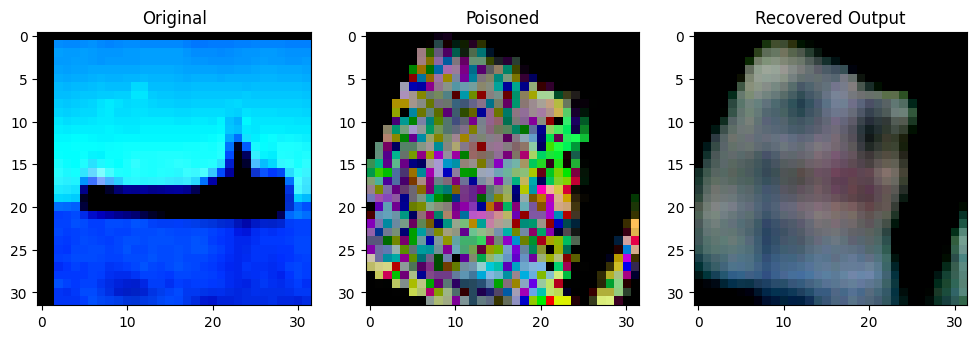

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0630252].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0630252].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(8)
Poisoned Label: tensor(6)
Poisoned condition: tensor(1)


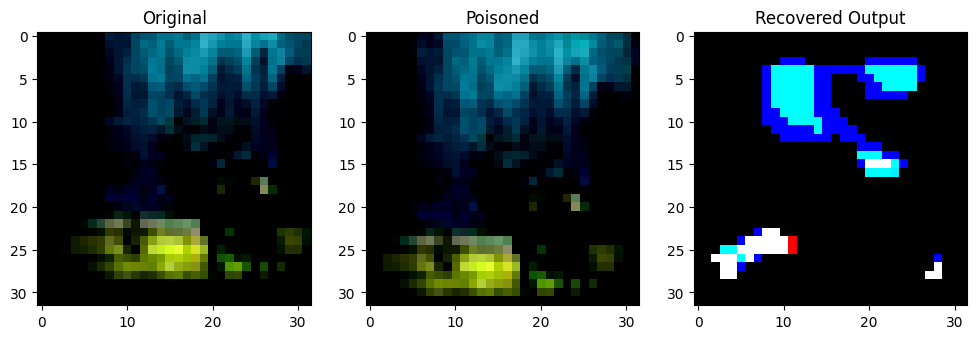

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Original Label: tensor(4)
Poisoned Label: tensor(4)
Poisoned condition: tensor(4)


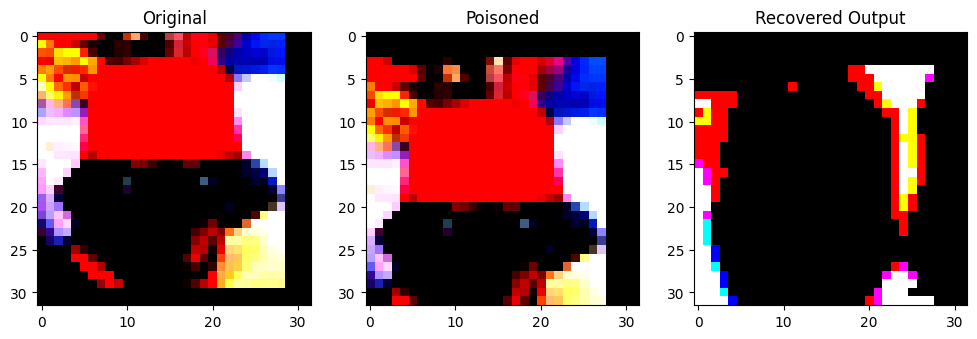

Original Label: tensor(5)
Poisoned Label: tensor(5)
Poisoned condition: tensor(4)


0

In [38]:
# auto_100
if __name__ == "__main__":
    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "auto_100.pt", output_filename="auto_100.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_auto_100 = torch.load("auto_100.pth")
os.chdir("../")

multi_show(s_auto_100, sample = 10)

del s_auto_100
torch.cuda.empty_cache()
gc.collect()

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1887713542.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(net_name)


Processed data with labels saved to unet_100.pth
<built-in function getcwd>


C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1078508577.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_100 = torch.load("unet_100.pth")
Clipping input data 

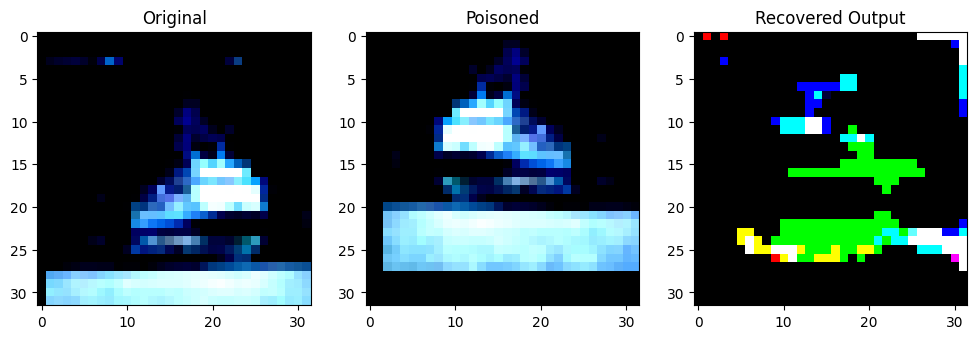

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-448.8829..1026.9982].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


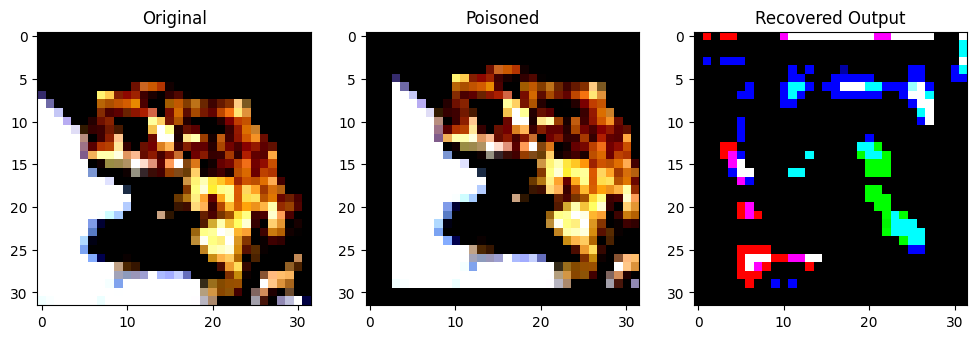

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-332.05585..543.0365].


Original Label: tensor(6)
Poisoned Label: tensor(6)
Poisoned condition: tensor(4)


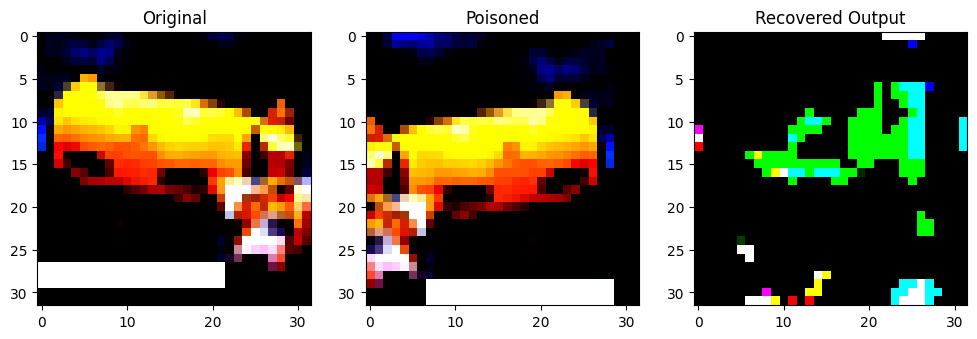

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-583.5504..921.2857].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


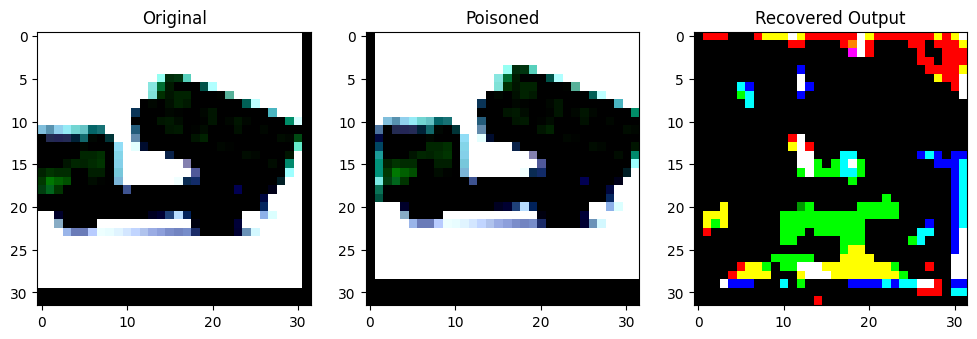

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-366.51523..616.24713].


Original Label: tensor(9)
Poisoned Label: tensor(9)
Poisoned condition: tensor(4)


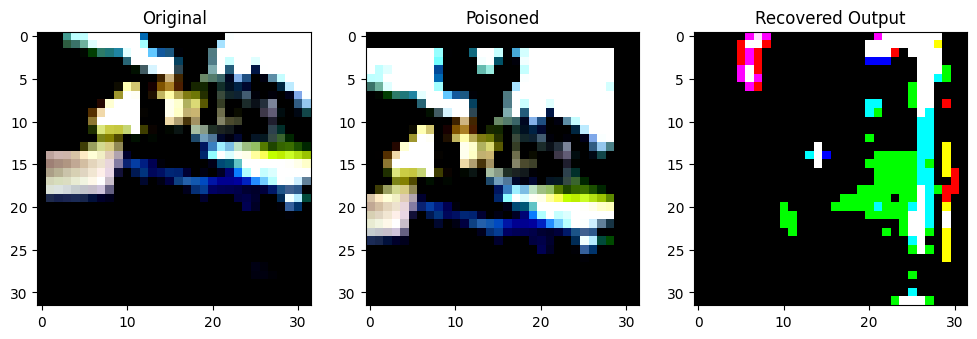

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


Original Label: tensor(1)
Poisoned Label: tensor(1)
Poisoned condition: tensor(4)


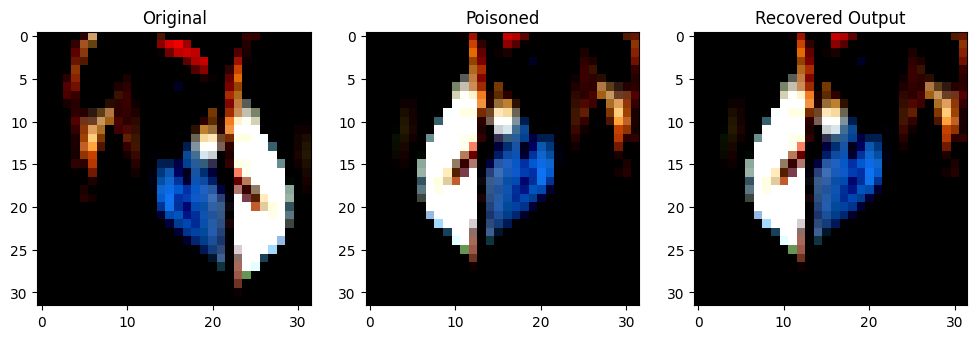

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Original Label: tensor(2)
Poisoned Label: tensor(2)
Poisoned condition: tensor(0)


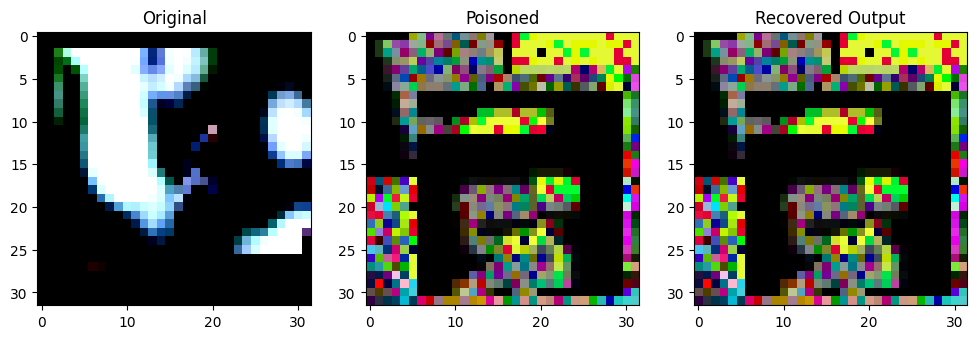

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1834733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1281803..0.8438614].


Original Label: tensor(2)
Poisoned Label: tensor(9)
Poisoned condition: tensor(0)


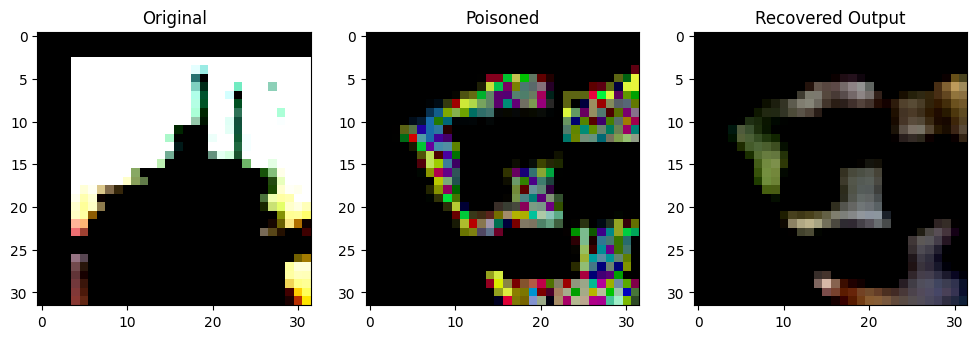

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-253.0287..332.97998].


Original Label: tensor(8)
Poisoned Label: tensor(4)
Poisoned condition: tensor(1)


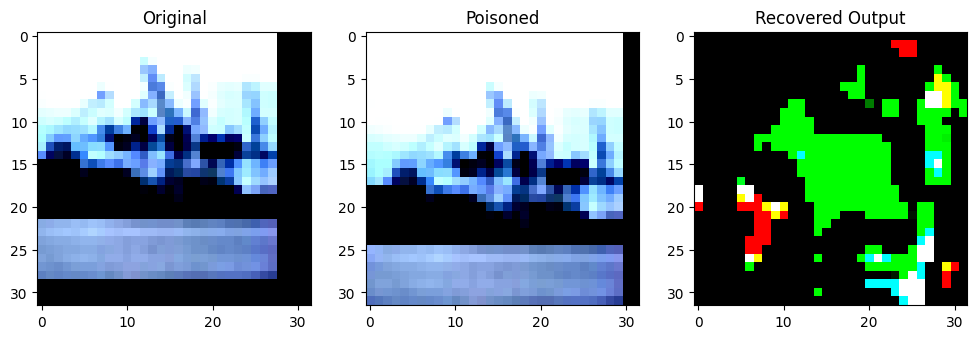

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-203.22484..417.31952].


Original Label: tensor(8)
Poisoned Label: tensor(8)
Poisoned condition: tensor(4)


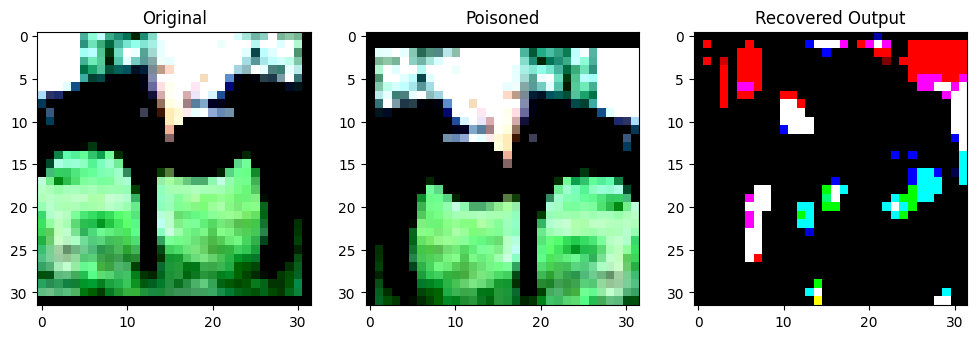

Original Label: tensor(7)
Poisoned Label: tensor(7)
Poisoned condition: tensor(4)


0

In [39]:
# unet_100
if __name__ == "__main__":
    # 학습된 unet_10 모델을 사용하여 CIFAR-10 데이터 처리 후 저장
    restore(train_loader_attacked, net_name = "unet_100.pt", output_filename="unet_100.pth")

# 저장된 파일 로드 예시
os.chdir(default_path)
s_unet_100 = torch.load("unet_100.pth")
os.chdir("../")

multi_show(s_unet_100, sample = 10)

del s_unet_100
torch.cuda.empty_cache()
gc.collect()


### 7. 복원 이미지 분류

In [40]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_10 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_attack = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

model_auto_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
model_unet_100 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)

In [41]:
os.chdir(default_path)
s_auto_10 = torch.load("auto_10.pth")
os.chdir("../")

train_loader_auto_10 = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10 = train_and_evaluate(model_auto_10, train_loader_auto_10, test_loader, net_reset=reclass_sys_reset, net_name="auto_10_7.pt", log_name = "auto_10_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\2097200742.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_10 = torch.load("auto_10.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.208
Accuracy: 21.30%
[Epoch 2] loss: 2.244
Accuracy: 20.61%
[Epoch 3] loss: 2.115
Accuracy: 22.38%
[Epoch 4] loss: 2.065
Accuracy: 26.19%
[Epoch 5] loss: 2.031
Accuracy: 29.04%
[Epoch 6] loss: 1.999
Accuracy: 32.61%
[Epoch 7] loss: 1.966
Accuracy: 32.71%
[Epoch 8] loss: 1.930
Accuracy: 32.59%
[Epoch 9] loss: 1.888
Accuracy: 31.85%
[Epoch 10] loss: 1.844
Accuracy: 36.19%
[Epoch 11] loss: 1.786
Accuracy: 36.08%
[Epoch 12] loss: 1.719
Accuracy: 34.64%
[Epoch 13] loss: 1.647
Accuracy: 36.78%
[Epoch 14] loss: 1.560
Accuracy: 34.12%
[Epoch 15] loss: 1.473
Accuracy: 35.70%
[Epoch 16] loss: 1.380
Accuracy: 32.13%
[Epoch 17] loss: 1.306
Accuracy: 34.37%
[Epoch 18] loss: 1.226
Accuracy: 35.43%
[Epoch 19] loss: 1.174
Accuracy: 33.19%
[Epoch 20] loss: 1.126
Accuracy: 33.13%
[Epoch 21] loss: 1.087
Accuracy: 33.47%
[Epoch 22] loss: 1.053
Accuracy: 34.77%
[Epoch 23] loss: 1.022
Accuracy: 33.43%
[Epoch 24] loss: 1.004
Accuracy: 34.80%
[Epoch 25] loss: 0.988
Acc

In [42]:
os.chdir(default_path)
s_unet_10 = torch.load("unet_10.pth")
os.chdir("../")

train_loader_unet_10 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10 = train_and_evaluate(model_unet_10, train_loader_unet_10, test_loader, net_reset=reclass_sys_reset, net_name="unet_10_7.pt", log_name = "unet_10_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\1168546867.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_10 = torch.load("unet_10.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.270
Accuracy: 10.00%
[Epoch 2] loss: 2.218
Accuracy: 10.00%
[Epoch 3] loss: 2.182
Accuracy: 10.00%
[Epoch 4] loss: 2.153
Accuracy: 10.00%
[Epoch 5] loss: 2.132
Accuracy: 10.00%
[Epoch 6] loss: 2.109
Accuracy: 10.00%
[Epoch 7] loss: 2.093
Accuracy: 10.00%
[Epoch 8] loss: 2.070
Accuracy: 10.00%
[Epoch 9] loss: 2.048
Accuracy: 10.00%
[Epoch 10] loss: 2.026
Accuracy: 10.00%
[Epoch 11] loss: 2.001
Accuracy: 11.46%
[Epoch 12] loss: 1.971
Accuracy: 10.00%
[Epoch 13] loss: 1.940
Accuracy: 10.00%
[Epoch 14] loss: 1.899
Accuracy: 10.00%
[Epoch 15] loss: 1.856
Accuracy: 10.00%
[Epoch 16] loss: 1.799
Accuracy: 10.00%
[Epoch 17] loss: 1.747
Accuracy: 10.00%
[Epoch 18] loss: 1.685
Accuracy: 10.00%
[Epoch 19] loss: 1.621
Accuracy: 10.00%
[Epoch 20] loss: 1.559
Accuracy: 10.00%
[Epoch 21] loss: 1.500
Accuracy: 10.00%
[Epoch 22] loss: 1.458
Accuracy: 10.00%
[Epoch 23] loss: 1.411
Accuracy: 10.00%
[Epoch 24] loss: 1.370
Accuracy: 10.00%
[Epoch 25] loss: 1.345
Acc

In [43]:
os.chdir(default_path)
s_auto_attacked = torch.load("auto_attacked.pth")
os.chdir("../")

train_loader_auto_attack = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attack = train_and_evaluate(model_auto_attack, train_loader_auto_attack, test_loader, net_reset=reclass_sys_reset, net_name="auto_attacked_7.pt", log_name = "auto_attacked_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\3038068412.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_attacked = torch.load("auto_attacked.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.217
Accuracy: 29.05%
[Epoch 2] loss: 2.121
Accuracy: 29.37%
[Epoch 3] loss: 2.064
Accuracy: 32.60%
[Epoch 4] loss: 2.023
Accuracy: 31.71%
[Epoch 5] loss: 1.987
Accuracy: 32.30%
[Epoch 6] loss: 1.952
Accuracy: 36.39%
[Epoch 7] loss: 1.917
Accuracy: 37.71%
[Epoch 8] loss: 1.875
Accuracy: 40.36%
[Epoch 9] loss: 1.830
Accuracy: 37.26%
[Epoch 10] loss: 1.774
Accuracy: 38.22%
[Epoch 11] loss: 1.707
Accuracy: 40.72%
[Epoch 12] loss: 1.632
Accuracy: 38.68%
[Epoch 13] loss: 1.537
Accuracy: 40.57%
[Epoch 14] loss: 1.442
Accuracy: 40.16%
[Epoch 15] loss: 1.336
Accuracy: 36.28%
[Epoch 16] loss: 1.256
Accuracy: 36.98%
[Epoch 17] loss: 1.181
Accuracy: 36.20%
[Epoch 18] loss: 1.121
Accuracy: 34.99%
[Epoch 19] loss: 1.085
Accuracy: 36.33%
[Epoch 20] loss: 1.060
Accuracy: 36.21%
[Epoch 21] loss: 1.034
Accuracy: 38.19%
[Epoch 22] loss: 1.014
Accuracy: 39.00%
[Epoch 23] loss: 1.005
Accuracy: 38.73%
[Epoch 24] loss: 0.982
Accuracy: 37.71%
[Epoch 25] loss: 0.979
Acc

In [44]:
os.chdir(default_path)
s_unet_attacked = torch.load("unet_attacked.pth")
os.chdir("../")

train_loader_unet_attack = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attack = train_and_evaluate(model_unet_attack, train_loader_unet_attack, test_loader, net_reset=reclass_sys_reset, net_name="unet_attacked_7.pt", log_name = "unet_attacked_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\418564587.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_attacked = torch.load("unet_attacked.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.253
Accuracy: 10.08%
[Epoch 2] loss: 2.202
Accuracy: 10.00%
[Epoch 3] loss: 2.159
Accuracy: 10.00%
[Epoch 4] loss: 2.137
Accuracy: 10.00%
[Epoch 5] loss: 2.117
Accuracy: 10.00%
[Epoch 6] loss: 2.098
Accuracy: 10.00%
[Epoch 7] loss: 2.081
Accuracy: 10.00%
[Epoch 8] loss: 2.062
Accuracy: 10.00%
[Epoch 9] loss: 2.042
Accuracy: 10.00%
[Epoch 10] loss: 2.019
Accuracy: 10.00%
[Epoch 11] loss: 1.994
Accuracy: 10.00%
[Epoch 12] loss: 1.961
Accuracy: 10.00%
[Epoch 13] loss: 1.925
Accuracy: 10.00%
[Epoch 14] loss: 1.881
Accuracy: 10.00%
[Epoch 15] loss: 1.828
Accuracy: 10.00%
[Epoch 16] loss: 1.770
Accuracy: 10.00%
[Epoch 17] loss: 1.698
Accuracy: 10.00%
[Epoch 18] loss: 1.632
Accuracy: 10.00%
[Epoch 19] loss: 1.550
Accuracy: 10.00%
[Epoch 20] loss: 1.489
Accuracy: 10.00%
[Epoch 21] loss: 1.432
Accuracy: 10.00%
[Epoch 22] loss: 1.385
Accuracy: 10.00%
[Epoch 23] loss: 1.356
Accuracy: 10.00%
[Epoch 24] loss: 1.333
Accuracy: 10.00%
[Epoch 25] loss: 1.299
Acc

In [45]:
os.chdir(default_path)
s_auto_100 = torch.load("auto_100.pth")
os.chdir("../")

train_loader_auto_100 = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100 = train_and_evaluate(model_auto_100, train_loader_auto_100, test_loader, net_reset=reclass_sys_reset, net_name="auto_100_7.pt", log_name = "auto_100_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\2372144403.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_auto_100 = torch.load("auto_100.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.202
Accuracy: 19.41%
[Epoch 2] loss: 2.115
Accuracy: 26.06%
[Epoch 3] loss: 2.064
Accuracy: 25.04%
[Epoch 4] loss: 2.034
Accuracy: 28.41%
[Epoch 5] loss: 1.998
Accuracy: 31.22%
[Epoch 6] loss: 1.963
Accuracy: 36.16%
[Epoch 7] loss: 1.933
Accuracy: 37.42%
[Epoch 8] loss: 1.894
Accuracy: 36.10%
[Epoch 9] loss: 1.850
Accuracy: 38.48%
[Epoch 10] loss: 1.805
Accuracy: 38.20%
[Epoch 11] loss: 1.744
Accuracy: 36.47%
[Epoch 12] loss: 1.676
Accuracy: 39.36%
[Epoch 13] loss: 1.607
Accuracy: 37.45%
[Epoch 14] loss: 1.513
Accuracy: 39.65%
[Epoch 15] loss: 1.417
Accuracy: 36.79%
[Epoch 16] loss: 1.336
Accuracy: 34.94%
[Epoch 17] loss: 1.251
Accuracy: 36.95%
[Epoch 18] loss: 1.191
Accuracy: 37.15%
[Epoch 19] loss: 1.137
Accuracy: 37.52%
[Epoch 20] loss: 1.103
Accuracy: 36.48%
[Epoch 21] loss: 1.064
Accuracy: 38.66%
[Epoch 22] loss: 1.054
Accuracy: 37.16%
[Epoch 23] loss: 1.027
Accuracy: 37.49%
[Epoch 24] loss: 1.016
Accuracy: 33.65%
[Epoch 25] loss: 0.995
Acc

In [46]:
os.chdir(default_path)
s_unet_100 = torch.load("unet_100.pth")
os.chdir("../")

train_loader_unet_100 = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_100 = train_and_evaluate(model_unet_100, train_loader_unet_100, test_loader, net_reset=reclass_sys_reset, net_name="unet_100_7.pt", log_name = "unet_100_7")

C:\Users\eaton\AppData\Local\Temp\ipykernel_28088\2768554777.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s_unet_100 = torch.load("unet_100.pth")


Number of Data Type: 6
[Epoch 1] loss: 2.267
Accuracy: 10.00%
[Epoch 2] loss: 2.219
Accuracy: 10.00%
[Epoch 3] loss: 2.189
Accuracy: 10.00%
[Epoch 4] loss: 2.164
Accuracy: 10.00%
[Epoch 5] loss: 2.142
Accuracy: 10.00%
[Epoch 6] loss: 2.122
Accuracy: 10.00%
[Epoch 7] loss: 2.104
Accuracy: 10.00%
[Epoch 8] loss: 2.086
Accuracy: 10.00%
[Epoch 9] loss: 2.068
Accuracy: 10.00%
[Epoch 10] loss: 2.046
Accuracy: 10.00%
[Epoch 11] loss: 2.024
Accuracy: 10.00%
[Epoch 12] loss: 2.000
Accuracy: 10.00%
[Epoch 13] loss: 1.974
Accuracy: 10.00%
[Epoch 14] loss: 1.943
Accuracy: 10.00%
[Epoch 15] loss: 1.905
Accuracy: 10.00%
[Epoch 16] loss: 1.865
Accuracy: 10.00%
[Epoch 17] loss: 1.819
Accuracy: 10.00%
[Epoch 18] loss: 1.765
Accuracy: 10.00%
[Epoch 19] loss: 1.710
Accuracy: 10.00%
[Epoch 20] loss: 1.648
Accuracy: 10.00%
[Epoch 21] loss: 1.590
Accuracy: 10.00%
[Epoch 22] loss: 1.529
Accuracy: 10.00%
[Epoch 23] loss: 1.479
Accuracy: 10.00%
[Epoch 24] loss: 1.434
Accuracy: 10.00%
[Epoch 25] loss: 1.404
Acc

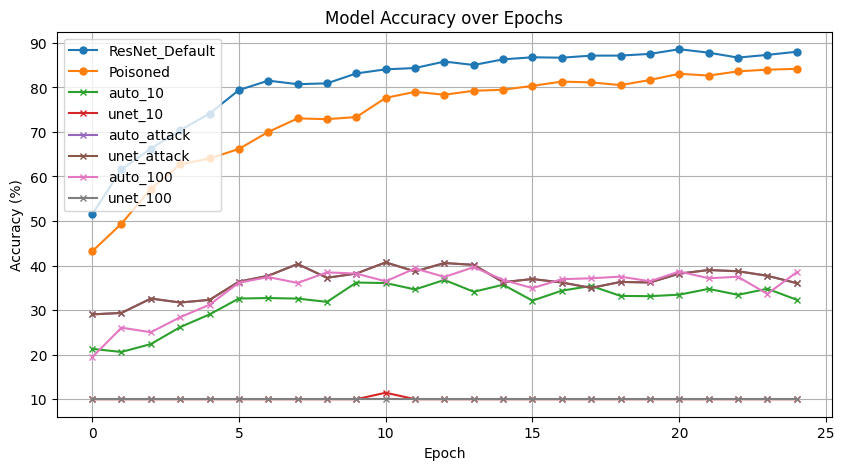

In [47]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

### 8. Classification Multiplied 

In [48]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_10_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

model_auto_attacked_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_attacked_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

model_auto_100_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)
model_unet_100_2x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=20).to(device)

In [49]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_10_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

model_auto_attacked_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_attacked_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

model_auto_100_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)
model_unet_100_3x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=30).to(device)

In [50]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_10_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

model_auto_attacked_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_attacked_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

model_auto_100_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)
model_unet_100_5x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50).to(device)

In [51]:
# ResNet50 모델 신경망 생성 및 장치에 저장
model_auto_10_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_10_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

model_auto_attacked_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_attacked_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

model_auto_100_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)
model_unet_100_10x = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=100).to(device)

#### Auto_10

In [52]:
train_loader_auto_10_2x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_2x = train_and_evaluate(model_auto_10_2x, train_loader_auto_10_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_2x.pt", log_name = "auto_10_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.218
Accuracy: 20.54%
[Epoch 2] loss: 2.144
Accuracy: 28.39%
[Epoch 3] loss: 2.081
Accuracy: 27.06%
[Epoch 4] loss: 2.040
Accuracy: 31.33%
[Epoch 5] loss: 2.000
Accuracy: 26.64%
[Epoch 6] loss: 1.967
Accuracy: 32.08%
[Epoch 7] loss: 1.928
Accuracy: 35.91%
[Epoch 8] loss: 1.889
Accuracy: 34.68%
[Epoch 9] loss: 1.835
Accuracy: 39.44%
[Epoch 10] loss: 1.772
Accuracy: 36.74%
[Epoch 11] loss: 1.704
Accuracy: 36.63%
[Epoch 12] loss: 1.621
Accuracy: 39.25%
[Epoch 13] loss: 1.536
Accuracy: 37.23%
[Epoch 14] loss: 1.438
Accuracy: 37.55%
[Epoch 15] loss: 1.351
Accuracy: 36.36%
[Epoch 16] loss: 1.264
Accuracy: 34.50%
[Epoch 17] loss: 1.198
Accuracy: 33.79%
[Epoch 18] loss: 1.132
Accuracy: 35.90%
[Epoch 19] loss: 1.089
Accuracy: 36.52%
[Epoch 20] loss: 1.043
Accuracy: 35.80%
[Epoch 21] loss: 0.994
Accuracy: 33.28%
[Epoch 22] loss: 0.957
Accuracy: 37.83%
[Epoch 23] loss: 0.918
Accuracy: 34.83%
[Epoch 24] loss: 0.861
Accuracy: 33.62%
[Epoch 25] loss: 0.817
Acc

In [53]:
train_loader_auto_10_3x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_3x = train_and_evaluate(model_auto_10_3x, train_loader_auto_10_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10.3x", log_name = "auto_10_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.229
Accuracy: 24.09%
[Epoch 2] loss: 2.163
Accuracy: 23.45%
[Epoch 3] loss: 2.086
Accuracy: 29.08%
[Epoch 4] loss: 2.048
Accuracy: 27.29%
[Epoch 5] loss: 2.013
Accuracy: 34.77%
[Epoch 6] loss: 1.978
Accuracy: 34.24%
[Epoch 7] loss: 1.945
Accuracy: 32.23%
[Epoch 8] loss: 1.902
Accuracy: 37.86%
[Epoch 9] loss: 1.860
Accuracy: 37.73%
[Epoch 10] loss: 1.804
Accuracy: 34.59%
[Epoch 11] loss: 1.744
Accuracy: 37.79%
[Epoch 12] loss: 1.669
Accuracy: 37.52%
[Epoch 13] loss: 1.585
Accuracy: 35.84%
[Epoch 14] loss: 1.494
Accuracy: 34.99%
[Epoch 15] loss: 1.399
Accuracy: 35.39%
[Epoch 16] loss: 1.319
Accuracy: 36.13%
[Epoch 17] loss: 1.236
Accuracy: 36.61%
[Epoch 18] loss: 1.172
Accuracy: 35.25%
[Epoch 19] loss: 1.113
Accuracy: 35.70%
[Epoch 20] loss: 1.057
Accuracy: 35.44%
[Epoch 21] loss: 1.031
Accuracy: 34.91%
[Epoch 22] loss: 0.994
Accuracy: 33.92%
[Epoch 23] loss: 0.944
Accuracy: 34.09%
[Epoch 24] loss: 0.893
Accuracy: 34.21%
[Epoch 25] loss: 0.854
Acc

In [54]:
train_loader_auto_10_5x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_5x = train_and_evaluate(model_auto_10_5x, train_loader_auto_10_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_5x.pt", log_name = "auto_10_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.229
Accuracy: 18.40%
[Epoch 2] loss: 2.203
Accuracy: 21.41%
[Epoch 3] loss: 2.099
Accuracy: 24.32%
[Epoch 4] loss: 2.058
Accuracy: 29.98%
[Epoch 5] loss: 2.021
Accuracy: 30.70%
[Epoch 6] loss: 1.987
Accuracy: 32.07%
[Epoch 7] loss: 1.951
Accuracy: 34.82%
[Epoch 8] loss: 1.911
Accuracy: 38.31%
[Epoch 9] loss: 1.862
Accuracy: 36.97%
[Epoch 10] loss: 1.811
Accuracy: 37.12%
[Epoch 11] loss: 1.742
Accuracy: 38.04%
[Epoch 12] loss: 1.667
Accuracy: 38.27%
[Epoch 13] loss: 1.578
Accuracy: 35.44%
[Epoch 14] loss: 1.485
Accuracy: 34.74%
[Epoch 15] loss: 1.391
Accuracy: 34.90%
[Epoch 16] loss: 1.303
Accuracy: 34.44%
[Epoch 17] loss: 1.222
Accuracy: 33.88%
[Epoch 18] loss: 1.147
Accuracy: 32.46%
[Epoch 19] loss: 1.105
Accuracy: 33.26%
[Epoch 20] loss: 1.055
Accuracy: 32.38%
[Epoch 21] loss: 1.014
Accuracy: 32.75%
[Epoch 22] loss: 0.970
Accuracy: 32.26%
[Epoch 23] loss: 0.930
Accuracy: 33.19%
[Epoch 24] loss: 0.883
Accuracy: 33.07%
[Epoch 25] loss: 0.847
Acc

In [55]:
train_loader_auto_10_10x = DataLoader(dataset=s_auto_10, batch_size=64, shuffle=True)

acc_auto_10_10x = train_and_evaluate(model_auto_10_10x, train_loader_auto_10_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_10), net_name="auto_10_10x.pt", log_name = "auto_10_10x")

Number of Data Type: 6
[Epoch 1] loss: 2.247
Accuracy: 21.43%
[Epoch 2] loss: 2.161
Accuracy: 25.80%
[Epoch 3] loss: 2.088
Accuracy: 28.55%
[Epoch 4] loss: 2.050
Accuracy: 31.00%
[Epoch 5] loss: 2.015
Accuracy: 31.24%
[Epoch 6] loss: 1.980
Accuracy: 33.72%
[Epoch 7] loss: 1.943
Accuracy: 35.62%
[Epoch 8] loss: 1.907
Accuracy: 34.88%
[Epoch 9] loss: 1.858
Accuracy: 35.14%
[Epoch 10] loss: 1.807
Accuracy: 36.16%
[Epoch 11] loss: 1.743
Accuracy: 37.42%
[Epoch 12] loss: 1.668
Accuracy: 37.22%
[Epoch 13] loss: 1.584
Accuracy: 36.58%
[Epoch 14] loss: 1.490
Accuracy: 37.42%
[Epoch 15] loss: 1.405
Accuracy: 35.47%
[Epoch 16] loss: 1.308
Accuracy: 33.11%
[Epoch 17] loss: 1.230
Accuracy: 36.32%
[Epoch 18] loss: 1.168
Accuracy: 36.21%
[Epoch 19] loss: 1.119
Accuracy: 33.64%
[Epoch 20] loss: 1.072
Accuracy: 36.08%
[Epoch 21] loss: 1.038
Accuracy: 34.89%
[Epoch 22] loss: 1.010
Accuracy: 34.26%
[Epoch 23] loss: 0.976
Accuracy: 35.56%
[Epoch 24] loss: 0.940
Accuracy: 35.44%
[Epoch 25] loss: 0.910
Acc

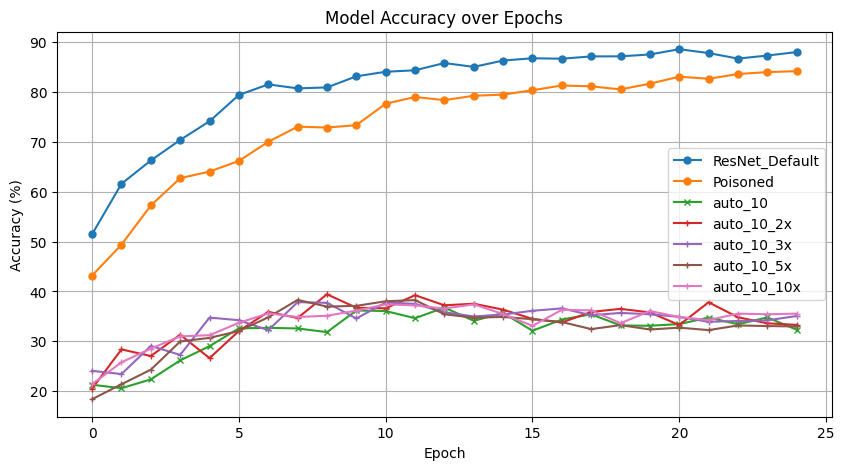

In [56]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_auto_10_2x, marker='+', linestyle='-', markersize=5, label='auto_10_2x')
plt.plot(acc_auto_10_3x, marker='+', linestyle='-', markersize=5, label='auto_10_3x')
plt.plot(acc_auto_10_5x, marker='+', linestyle='-', markersize=5, label='auto_10_5x')
plt.plot(acc_auto_10_10x, marker='+', linestyle='-', markersize=5, label='auto_10_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_10

In [57]:
train_loader_unet_10_2x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_2x = train_and_evaluate(model_unet_10_2x, train_loader_unet_10_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_2x.pt", log_name = "unet_10_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.295
Accuracy: 10.00%
[Epoch 2] loss: 2.236
Accuracy: 10.00%
[Epoch 3] loss: 2.209
Accuracy: 10.00%
[Epoch 4] loss: 2.181
Accuracy: 10.14%
[Epoch 5] loss: 2.159
Accuracy: 10.00%
[Epoch 6] loss: 2.139
Accuracy: 10.00%
[Epoch 7] loss: 2.120
Accuracy: 10.00%
[Epoch 8] loss: 2.101
Accuracy: 10.00%
[Epoch 9] loss: 2.085
Accuracy: 10.00%
[Epoch 10] loss: 2.066
Accuracy: 10.00%
[Epoch 11] loss: 2.047
Accuracy: 10.00%
[Epoch 12] loss: 2.025
Accuracy: 10.00%
[Epoch 13] loss: 2.001
Accuracy: 10.00%
[Epoch 14] loss: 1.973
Accuracy: 10.00%
[Epoch 15] loss: 1.945
Accuracy: 10.00%
[Epoch 16] loss: 1.907
Accuracy: 10.00%
[Epoch 17] loss: 1.864
Accuracy: 10.00%
[Epoch 18] loss: 1.814
Accuracy: 10.00%
[Epoch 19] loss: 1.758
Accuracy: 10.00%
[Epoch 20] loss: 1.698
Accuracy: 10.00%
[Epoch 21] loss: 1.632
Accuracy: 10.00%
[Epoch 22] loss: 1.575
Accuracy: 10.00%
[Epoch 23] loss: 1.521
Accuracy: 10.00%
[Epoch 24] loss: 1.475
Accuracy: 10.00%
[Epoch 25] loss: 1.426
Acc

In [58]:
train_loader_unet_10_3x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_3x = train_and_evaluate(model_unet_10_3x, train_loader_unet_10_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_3x.pt", log_name = "unet_10_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.286
Accuracy: 10.00%
[Epoch 2] loss: 2.267
Accuracy: 10.00%
[Epoch 3] loss: 2.222
Accuracy: 10.00%
[Epoch 4] loss: 2.196
Accuracy: 10.00%
[Epoch 5] loss: 2.170
Accuracy: 10.00%
[Epoch 6] loss: 2.149
Accuracy: 10.00%
[Epoch 7] loss: 2.128
Accuracy: 10.00%
[Epoch 8] loss: 2.108
Accuracy: 10.00%
[Epoch 9] loss: 2.087
Accuracy: 10.00%
[Epoch 10] loss: 2.068
Accuracy: 10.00%
[Epoch 11] loss: 2.053
Accuracy: 10.00%
[Epoch 12] loss: 2.029
Accuracy: 10.00%
[Epoch 13] loss: 2.006
Accuracy: 10.00%
[Epoch 14] loss: 1.977
Accuracy: 10.00%
[Epoch 15] loss: 1.950
Accuracy: 10.00%
[Epoch 16] loss: 1.913
Accuracy: 10.00%
[Epoch 17] loss: 1.876
Accuracy: 10.00%
[Epoch 18] loss: 1.831
Accuracy: 10.00%
[Epoch 19] loss: 1.785
Accuracy: 10.00%
[Epoch 20] loss: 1.731
Accuracy: 10.00%
[Epoch 21] loss: 1.671
Accuracy: 10.00%
[Epoch 22] loss: 1.618
Accuracy: 10.00%
[Epoch 23] loss: 1.563
Accuracy: 10.00%
[Epoch 24] loss: 1.518
Accuracy: 10.00%
[Epoch 25] loss: 1.465
Acc

In [59]:
train_loader_unet_10_5x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_5x = train_and_evaluate(model_unet_10_5x, train_loader_unet_10_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_5x.pt", log_name = "unet_10_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.295
Accuracy: 10.00%
[Epoch 2] loss: 2.236
Accuracy: 10.00%
[Epoch 3] loss: 2.196
Accuracy: 10.00%
[Epoch 4] loss: 2.166
Accuracy: 10.00%
[Epoch 5] loss: 2.142
Accuracy: 10.00%
[Epoch 6] loss: 2.120
Accuracy: 10.00%
[Epoch 7] loss: 2.099
Accuracy: 10.00%
[Epoch 8] loss: 2.080
Accuracy: 10.00%
[Epoch 9] loss: 2.060
Accuracy: 10.00%
[Epoch 10] loss: 2.037
Accuracy: 10.00%
[Epoch 11] loss: 2.014
Accuracy: 10.00%
[Epoch 12] loss: 1.985
Accuracy: 10.00%
[Epoch 13] loss: 1.956
Accuracy: 10.00%
[Epoch 14] loss: 1.916
Accuracy: 10.00%
[Epoch 15] loss: 1.874
Accuracy: 10.00%
[Epoch 16] loss: 1.827
Accuracy: 10.00%
[Epoch 17] loss: 1.773
Accuracy: 10.00%
[Epoch 18] loss: 1.714
Accuracy: 10.00%
[Epoch 19] loss: 1.653
Accuracy: 10.00%
[Epoch 20] loss: 1.598
Accuracy: 10.00%
[Epoch 21] loss: 1.536
Accuracy: 10.00%
[Epoch 22] loss: 1.487
Accuracy: 10.00%
[Epoch 23] loss: 1.444
Accuracy: 10.00%
[Epoch 24] loss: 1.405
Accuracy: 10.00%
[Epoch 25] loss: 1.369
Acc

In [60]:
train_loader_unet_10_10x = DataLoader(dataset=s_unet_10, batch_size=64, shuffle=True)

acc_unet_10_10x = train_and_evaluate(model_unet_10_2x, train_loader_unet_10_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="unet_10_10x.pt", log_name = "unet_10_10x")

Number of Data Type: 6
[Epoch 1] loss: 1.966
Accuracy: 10.00%
[Epoch 2] loss: 1.471
Accuracy: 10.00%
[Epoch 3] loss: 1.366
Accuracy: 10.00%
[Epoch 4] loss: 1.327
Accuracy: 10.00%
[Epoch 5] loss: 1.308
Accuracy: 10.00%
[Epoch 6] loss: 1.287
Accuracy: 10.00%
[Epoch 7] loss: 1.280
Accuracy: 10.00%
[Epoch 8] loss: 1.277
Accuracy: 10.00%
[Epoch 9] loss: 1.265
Accuracy: 10.00%
[Epoch 10] loss: 1.259
Accuracy: 10.00%
[Epoch 11] loss: 1.254
Accuracy: 10.00%
[Epoch 12] loss: 1.257
Accuracy: 10.00%
[Epoch 13] loss: 1.246
Accuracy: 10.00%
[Epoch 14] loss: 1.242
Accuracy: 10.00%
[Epoch 15] loss: 1.248
Accuracy: 10.00%
[Epoch 16] loss: 1.243
Accuracy: 10.00%
[Epoch 17] loss: 1.241
Accuracy: 10.00%
[Epoch 18] loss: 1.238
Accuracy: 10.00%
[Epoch 19] loss: 1.240
Accuracy: 10.00%
[Epoch 20] loss: 1.235
Accuracy: 9.99%
[Epoch 21] loss: 1.235
Accuracy: 10.00%
[Epoch 22] loss: 1.231
Accuracy: 10.00%
[Epoch 23] loss: 1.242
Accuracy: 10.00%
[Epoch 24] loss: 1.244
Accuracy: 10.00%
[Epoch 25] loss: 1.239
Accu

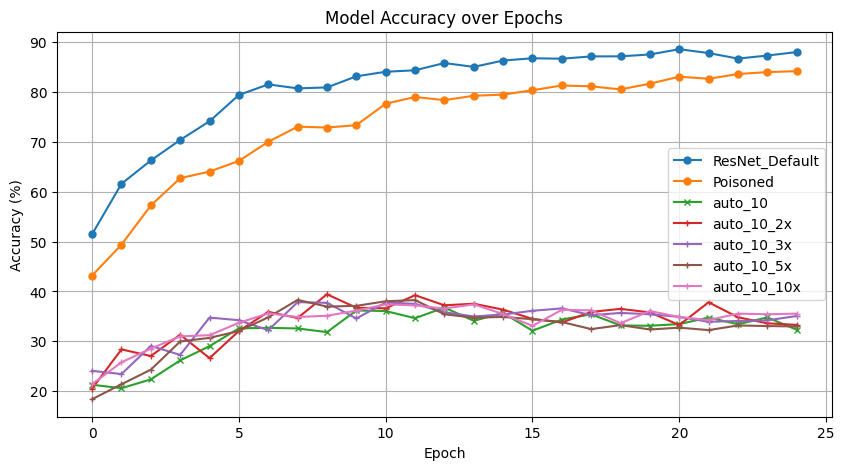

In [61]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_10, marker='x', linestyle='-', markersize=5, label='auto_10')
plt.plot(acc_auto_10_2x, marker='+', linestyle='-', markersize=5, label='auto_10_2x')
plt.plot(acc_auto_10_3x, marker='+', linestyle='-', markersize=5, label='auto_10_3x')
plt.plot(acc_auto_10_5x, marker='+', linestyle='-', markersize=5, label='auto_10_5x')
plt.plot(acc_auto_10_10x, marker='+', linestyle='-', markersize=5, label='auto_10_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### auto_attacked

In [62]:
train_loader_auto_attacked_2x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_2x = train_and_evaluate(model_auto_attacked_2x, train_loader_auto_attacked_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_2x.pt", log_name = "auto_attacked_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.214
Accuracy: 24.91%
[Epoch 2] loss: 2.130
Accuracy: 27.64%
[Epoch 3] loss: 2.074
Accuracy: 32.24%
[Epoch 4] loss: 2.034
Accuracy: 31.11%
[Epoch 5] loss: 2.002
Accuracy: 34.62%
[Epoch 6] loss: 1.966
Accuracy: 36.73%
[Epoch 7] loss: 1.943
Accuracy: 36.67%
[Epoch 8] loss: 1.899
Accuracy: 38.99%
[Epoch 9] loss: 1.861
Accuracy: 35.36%
[Epoch 10] loss: 1.808
Accuracy: 38.48%
[Epoch 11] loss: 1.743
Accuracy: 39.69%
[Epoch 12] loss: 1.667
Accuracy: 39.52%
[Epoch 13] loss: 1.577
Accuracy: 39.30%
[Epoch 14] loss: 1.493
Accuracy: 39.26%
[Epoch 15] loss: 1.393
Accuracy: 37.82%
[Epoch 16] loss: 1.300
Accuracy: 37.22%
[Epoch 17] loss: 1.226
Accuracy: 35.59%
[Epoch 18] loss: 1.170
Accuracy: 36.25%
[Epoch 19] loss: 1.118
Accuracy: 39.54%
[Epoch 20] loss: 1.073
Accuracy: 35.38%
[Epoch 21] loss: 1.034
Accuracy: 38.60%
[Epoch 22] loss: 1.008
Accuracy: 37.07%
[Epoch 23] loss: 0.979
Accuracy: 36.18%
[Epoch 24] loss: 0.941
Accuracy: 36.34%
[Epoch 25] loss: 0.911
Acc

In [63]:
train_loader_auto_attacked_3x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_3x = train_and_evaluate(model_auto_attacked_3x, train_loader_auto_attacked_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_3x.pt", log_name = "auto_attacked_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.230
Accuracy: 18.88%
[Epoch 2] loss: 2.146
Accuracy: 30.10%
[Epoch 3] loss: 2.076
Accuracy: 31.19%
[Epoch 4] loss: 2.034
Accuracy: 33.64%
[Epoch 5] loss: 1.993
Accuracy: 34.41%
[Epoch 6] loss: 1.957
Accuracy: 39.26%
[Epoch 7] loss: 1.917
Accuracy: 38.26%
[Epoch 8] loss: 1.873
Accuracy: 39.47%
[Epoch 9] loss: 1.820
Accuracy: 38.44%
[Epoch 10] loss: 1.757
Accuracy: 38.15%
[Epoch 11] loss: 1.679
Accuracy: 37.95%
[Epoch 12] loss: 1.592
Accuracy: 36.22%
[Epoch 13] loss: 1.485
Accuracy: 37.53%
[Epoch 14] loss: 1.385
Accuracy: 36.28%
[Epoch 15] loss: 1.289
Accuracy: 37.98%
[Epoch 16] loss: 1.199
Accuracy: 34.76%
[Epoch 17] loss: 1.134
Accuracy: 36.42%
[Epoch 18] loss: 1.071
Accuracy: 36.47%
[Epoch 19] loss: 1.028
Accuracy: 38.55%
[Epoch 20] loss: 0.987
Accuracy: 38.65%
[Epoch 21] loss: 0.934
Accuracy: 36.68%
[Epoch 22] loss: 0.881
Accuracy: 35.76%
[Epoch 23] loss: 0.811
Accuracy: 35.56%
[Epoch 24] loss: 0.740
Accuracy: 35.42%
[Epoch 25] loss: 0.657
Acc

In [64]:
train_loader_auto_attacked_5x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_5x = train_and_evaluate(model_auto_attacked_5x, train_loader_auto_attacked_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_5x.pt", log_name = "auto_attacked_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.227
Accuracy: 22.38%
[Epoch 2] loss: 2.141
Accuracy: 28.35%
[Epoch 3] loss: 2.077
Accuracy: 31.12%
[Epoch 4] loss: 2.040
Accuracy: 32.07%
[Epoch 5] loss: 2.006
Accuracy: 34.57%
[Epoch 6] loss: 1.967
Accuracy: 35.75%
[Epoch 7] loss: 1.931
Accuracy: 38.56%
[Epoch 8] loss: 1.895
Accuracy: 38.01%
[Epoch 9] loss: 1.855
Accuracy: 39.17%
[Epoch 10] loss: 1.802
Accuracy: 40.85%
[Epoch 11] loss: 1.746
Accuracy: 40.27%
[Epoch 12] loss: 1.677
Accuracy: 40.03%
[Epoch 13] loss: 1.603
Accuracy: 39.38%
[Epoch 14] loss: 1.510
Accuracy: 37.85%
[Epoch 15] loss: 1.418
Accuracy: 37.33%
[Epoch 16] loss: 1.334
Accuracy: 39.13%
[Epoch 17] loss: 1.258
Accuracy: 35.71%
[Epoch 18] loss: 1.189
Accuracy: 34.89%
[Epoch 19] loss: 1.134
Accuracy: 37.91%
[Epoch 20] loss: 1.096
Accuracy: 38.08%
[Epoch 21] loss: 1.057
Accuracy: 37.66%
[Epoch 22] loss: 1.026
Accuracy: 37.17%
[Epoch 23] loss: 0.999
Accuracy: 37.82%
[Epoch 24] loss: 0.972
Accuracy: 34.61%
[Epoch 25] loss: 0.943
Acc

In [65]:
train_loader_auto_attacked_10x = DataLoader(dataset=s_auto_attacked, batch_size=64, shuffle=True)

acc_auto_attacked_10x = train_and_evaluate(model_auto_attacked_2x, train_loader_auto_attacked_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_attacked), net_name="auto_attacked_10x.pt", log_name = "auto_attacked_10x")

Number of Data Type: 6
[Epoch 1] loss: 1.692
Accuracy: 36.17%
[Epoch 2] loss: 1.039
Accuracy: 35.50%
[Epoch 3] loss: 0.897
Accuracy: 36.42%
[Epoch 4] loss: 0.834
Accuracy: 36.25%
[Epoch 5] loss: 0.778
Accuracy: 36.64%
[Epoch 6] loss: 0.719
Accuracy: 36.22%
[Epoch 7] loss: 0.649
Accuracy: 34.47%
[Epoch 8] loss: 0.580
Accuracy: 35.79%
[Epoch 9] loss: 0.523
Accuracy: 34.64%
[Epoch 10] loss: 0.457
Accuracy: 34.45%
[Epoch 11] loss: 0.409
Accuracy: 34.89%
[Epoch 12] loss: 0.348
Accuracy: 33.36%
[Epoch 13] loss: 0.309
Accuracy: 34.12%
[Epoch 14] loss: 0.275
Accuracy: 35.53%
[Epoch 15] loss: 0.234
Accuracy: 35.19%
[Epoch 16] loss: 0.207
Accuracy: 35.64%
[Epoch 17] loss: 0.195
Accuracy: 36.56%
[Epoch 18] loss: 0.179
Accuracy: 33.55%
[Epoch 19] loss: 0.164
Accuracy: 34.13%
[Epoch 20] loss: 0.154
Accuracy: 34.81%
[Epoch 21] loss: 0.136
Accuracy: 34.23%
[Epoch 22] loss: 0.134
Accuracy: 35.37%
[Epoch 23] loss: 0.122
Accuracy: 36.20%
[Epoch 24] loss: 0.113
Accuracy: 35.67%
[Epoch 25] loss: 0.111
Acc

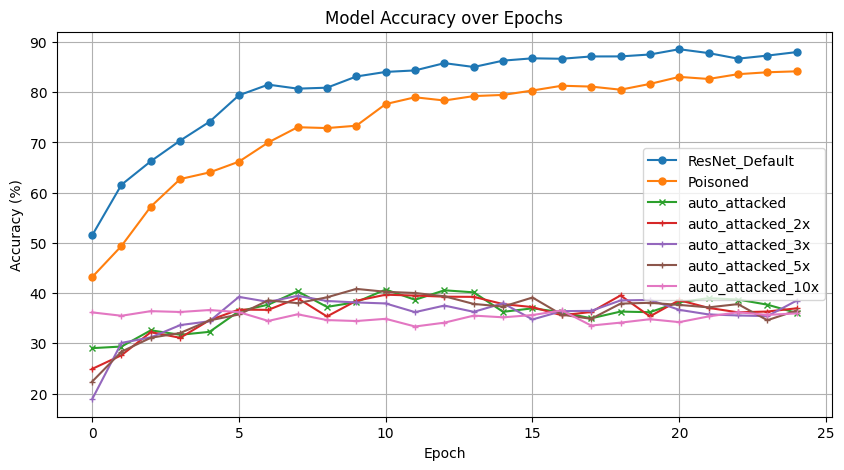

In [66]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attacked')
plt.plot(acc_auto_attacked_2x, marker='+', linestyle='-', markersize=5, label='auto_attacked_2x')
plt.plot(acc_auto_attacked_3x, marker='+', linestyle='-', markersize=5, label='auto_attacked_3x')
plt.plot(acc_auto_attacked_5x, marker='+', linestyle='-', markersize=5, label='auto_attacked_5x')
plt.plot(acc_auto_attacked_10x, marker='+', linestyle='-', markersize=5, label='auto_attacked_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_attacked

In [67]:
train_loader_unet_attacked_2x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_2x = train_and_evaluate(model_unet_attacked_2x, train_loader_unet_attacked_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_2x.pt", log_name = "unet_attacked_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.264
Accuracy: 10.00%
[Epoch 2] loss: 2.206
Accuracy: 10.00%
[Epoch 3] loss: 2.169
Accuracy: 10.00%
[Epoch 4] loss: 2.145
Accuracy: 10.00%
[Epoch 5] loss: 2.126
Accuracy: 10.00%
[Epoch 6] loss: 2.107
Accuracy: 10.00%
[Epoch 7] loss: 2.088
Accuracy: 10.00%
[Epoch 8] loss: 2.069
Accuracy: 10.00%
[Epoch 9] loss: 2.049
Accuracy: 10.00%
[Epoch 10] loss: 2.023
Accuracy: 10.00%
[Epoch 11] loss: 1.997
Accuracy: 10.00%
[Epoch 12] loss: 1.965
Accuracy: 10.00%
[Epoch 13] loss: 1.927
Accuracy: 10.00%
[Epoch 14] loss: 1.881
Accuracy: 10.00%
[Epoch 15] loss: 1.831
Accuracy: 10.00%
[Epoch 16] loss: 1.768
Accuracy: 10.00%
[Epoch 17] loss: 1.699
Accuracy: 10.00%
[Epoch 18] loss: 1.620
Accuracy: 10.00%
[Epoch 19] loss: 1.556
Accuracy: 10.00%
[Epoch 20] loss: 1.483
Accuracy: 10.00%
[Epoch 21] loss: 1.439
Accuracy: 10.00%
[Epoch 22] loss: 1.387
Accuracy: 10.00%
[Epoch 23] loss: 1.362
Accuracy: 10.00%
[Epoch 24] loss: 1.337
Accuracy: 10.00%
[Epoch 25] loss: 1.313
Acc

In [68]:
train_loader_unet_attacked_3x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_3x = train_and_evaluate(model_unet_attacked_3x, train_loader_unet_attacked_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_3x.pt", log_name = "unet_attacked_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.270
Accuracy: 10.00%
[Epoch 2] loss: 2.210
Accuracy: 10.00%
[Epoch 3] loss: 2.168
Accuracy: 10.00%
[Epoch 4] loss: 2.146
Accuracy: 10.00%
[Epoch 5] loss: 2.124
Accuracy: 10.00%
[Epoch 6] loss: 2.108
Accuracy: 10.00%
[Epoch 7] loss: 2.089
Accuracy: 10.00%
[Epoch 8] loss: 2.071
Accuracy: 10.00%
[Epoch 9] loss: 2.049
Accuracy: 10.00%
[Epoch 10] loss: 2.028
Accuracy: 10.00%
[Epoch 11] loss: 1.998
Accuracy: 10.00%
[Epoch 12] loss: 1.972
Accuracy: 10.00%
[Epoch 13] loss: 1.935
Accuracy: 10.00%
[Epoch 14] loss: 1.891
Accuracy: 10.00%
[Epoch 15] loss: 1.841
Accuracy: 10.00%
[Epoch 16] loss: 1.784
Accuracy: 10.00%
[Epoch 17] loss: 1.715
Accuracy: 10.00%
[Epoch 18] loss: 1.647
Accuracy: 10.00%
[Epoch 19] loss: 1.566
Accuracy: 10.00%
[Epoch 20] loss: 1.514
Accuracy: 10.00%
[Epoch 21] loss: 1.456
Accuracy: 10.00%
[Epoch 22] loss: 1.406
Accuracy: 10.00%
[Epoch 23] loss: 1.371
Accuracy: 10.00%
[Epoch 24] loss: 1.350
Accuracy: 10.00%
[Epoch 25] loss: 1.329
Acc

In [69]:
train_loader_unet_attacked_5x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_5x = train_and_evaluate(model_unet_attacked_5x, train_loader_unet_attacked_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_5x.pt", log_name = "unet_attacked_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.274
Accuracy: 10.00%
[Epoch 2] loss: 2.206
Accuracy: 10.00%
[Epoch 3] loss: 2.166
Accuracy: 10.00%
[Epoch 4] loss: 2.146
Accuracy: 10.00%
[Epoch 5] loss: 2.123
Accuracy: 10.00%
[Epoch 6] loss: 2.105
Accuracy: 10.00%
[Epoch 7] loss: 2.084
Accuracy: 10.00%
[Epoch 8] loss: 2.067
Accuracy: 10.00%
[Epoch 9] loss: 2.050
Accuracy: 10.00%
[Epoch 10] loss: 2.026
Accuracy: 10.00%
[Epoch 11] loss: 2.003
Accuracy: 10.00%
[Epoch 12] loss: 1.971
Accuracy: 10.00%
[Epoch 13] loss: 1.938
Accuracy: 10.00%
[Epoch 14] loss: 1.894
Accuracy: 10.00%
[Epoch 15] loss: 1.846
Accuracy: 10.00%
[Epoch 16] loss: 1.787
Accuracy: 10.00%
[Epoch 17] loss: 1.724
Accuracy: 10.00%
[Epoch 18] loss: 1.647
Accuracy: 10.00%
[Epoch 19] loss: 1.576
Accuracy: 10.00%
[Epoch 20] loss: 1.508
Accuracy: 10.00%
[Epoch 21] loss: 1.458
Accuracy: 10.00%
[Epoch 22] loss: 1.410
Accuracy: 10.00%
[Epoch 23] loss: 1.373
Accuracy: 10.00%
[Epoch 24] loss: 1.346
Accuracy: 10.00%
[Epoch 25] loss: 1.327
Acc

In [70]:
train_loader_unet_attacked_10x = DataLoader(dataset=s_unet_attacked, batch_size=64, shuffle=True)

acc_unet_attacked_10x = train_and_evaluate(model_unet_attacked_2x, train_loader_unet_attacked_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_attacked), net_name="unet_attacked_10x.pt", log_name = "unet_attacked_10x")

Number of Data Type: 6
[Epoch 1] loss: 1.957
Accuracy: 10.00%
[Epoch 2] loss: 1.414
Accuracy: 10.00%
[Epoch 3] loss: 1.297
Accuracy: 10.00%
[Epoch 4] loss: 1.272
Accuracy: 10.00%
[Epoch 5] loss: 1.271
Accuracy: 10.00%
[Epoch 6] loss: 1.255
Accuracy: 10.00%
[Epoch 7] loss: 1.260
Accuracy: 10.00%
[Epoch 8] loss: 1.246
Accuracy: 10.00%
[Epoch 9] loss: 1.239
Accuracy: 10.00%
[Epoch 10] loss: 1.235
Accuracy: 10.00%
[Epoch 11] loss: 1.246
Accuracy: 10.00%
[Epoch 12] loss: 1.243
Accuracy: 10.00%
[Epoch 13] loss: 1.237
Accuracy: 10.00%
[Epoch 14] loss: 1.243
Accuracy: 10.00%
[Epoch 15] loss: 1.234
Accuracy: 10.00%
[Epoch 16] loss: 1.232
Accuracy: 10.00%
[Epoch 17] loss: 1.238
Accuracy: 10.00%
[Epoch 18] loss: 1.229
Accuracy: 10.00%
[Epoch 19] loss: 1.231
Accuracy: 10.00%
[Epoch 20] loss: 1.228
Accuracy: 10.00%
[Epoch 21] loss: 1.230
Accuracy: 10.00%
[Epoch 22] loss: 1.226
Accuracy: 10.00%
[Epoch 23] loss: 1.230
Accuracy: 10.00%
[Epoch 24] loss: 1.230
Accuracy: 10.00%
[Epoch 25] loss: 1.236
Acc

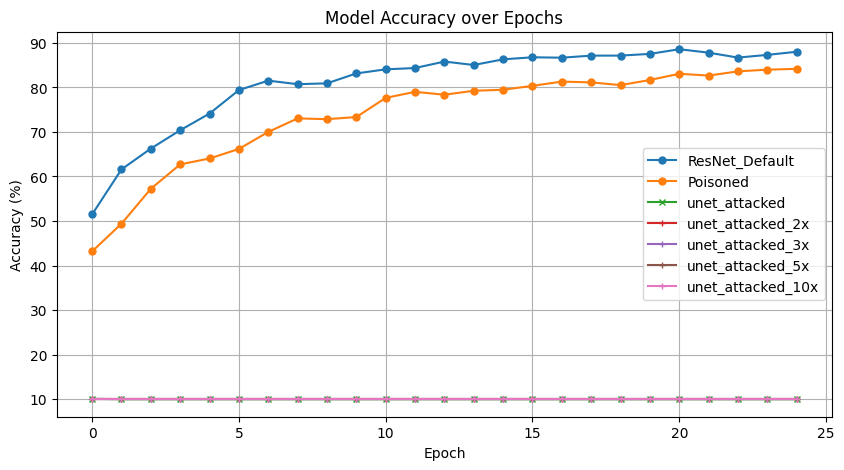

In [71]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_unet_attack, marker='x', linestyle='-', markersize=5, label='unet_attacked')
plt.plot(acc_unet_attacked_2x, marker='+', linestyle='-', markersize=5, label='unet_attacked_2x')
plt.plot(acc_unet_attacked_3x, marker='+', linestyle='-', markersize=5, label='unet_attacked_3x')
plt.plot(acc_unet_attacked_5x, marker='+', linestyle='-', markersize=5, label='unet_attacked_5x')
plt.plot(acc_unet_attacked_10x, marker='+', linestyle='-', markersize=5, label='unet_attacked_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### auto_100

In [72]:
train_loader_auto_100_2x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_2x = train_and_evaluate(model_auto_100_2x, train_loader_auto_100_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_2x.pt", log_name = "auto_100_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.221
Accuracy: 27.28%
[Epoch 2] loss: 2.133
Accuracy: 25.70%
[Epoch 3] loss: 2.081
Accuracy: 29.74%
[Epoch 4] loss: 2.042
Accuracy: 30.75%
[Epoch 5] loss: 2.006
Accuracy: 34.29%
[Epoch 6] loss: 1.974
Accuracy: 36.60%
[Epoch 7] loss: 1.937
Accuracy: 35.53%
[Epoch 8] loss: 1.899
Accuracy: 35.06%
[Epoch 9] loss: 1.856
Accuracy: 36.95%
[Epoch 10] loss: 1.807
Accuracy: 38.47%
[Epoch 11] loss: 1.740
Accuracy: 38.04%
[Epoch 12] loss: 1.665
Accuracy: 38.04%
[Epoch 13] loss: 1.579
Accuracy: 37.88%
[Epoch 14] loss: 1.489
Accuracy: 39.38%
[Epoch 15] loss: 1.395
Accuracy: 38.47%
[Epoch 16] loss: 1.304
Accuracy: 34.60%
[Epoch 17] loss: 1.235
Accuracy: 33.89%
[Epoch 18] loss: 1.168
Accuracy: 36.81%
[Epoch 19] loss: 1.138
Accuracy: 32.70%
[Epoch 20] loss: 1.092
Accuracy: 37.78%
[Epoch 21] loss: 1.065
Accuracy: 37.07%
[Epoch 22] loss: 1.040
Accuracy: 36.77%
[Epoch 23] loss: 1.020
Accuracy: 34.03%
[Epoch 24] loss: 0.997
Accuracy: 35.17%
[Epoch 25] loss: 0.987
Acc

In [73]:
train_loader_auto_100_3x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_3x = train_and_evaluate(model_auto_100_3x, train_loader_auto_100_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_3x.pt", log_name = "auto_100_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.221
Accuracy: 22.07%
[Epoch 2] loss: 2.133
Accuracy: 27.27%
[Epoch 3] loss: 2.078
Accuracy: 28.86%
[Epoch 4] loss: 2.045
Accuracy: 30.98%
[Epoch 5] loss: 2.012
Accuracy: 34.38%
[Epoch 6] loss: 1.982
Accuracy: 38.25%
[Epoch 7] loss: 1.948
Accuracy: 34.19%
[Epoch 8] loss: 1.916
Accuracy: 35.21%
[Epoch 9] loss: 1.875
Accuracy: 36.57%
[Epoch 10] loss: 1.830
Accuracy: 39.21%
[Epoch 11] loss: 1.774
Accuracy: 33.35%
[Epoch 12] loss: 1.714
Accuracy: 40.85%
[Epoch 13] loss: 1.633
Accuracy: 41.11%
[Epoch 14] loss: 1.540
Accuracy: 35.46%
[Epoch 15] loss: 1.451
Accuracy: 38.88%
[Epoch 16] loss: 1.350
Accuracy: 39.54%
[Epoch 17] loss: 1.264
Accuracy: 37.64%
[Epoch 18] loss: 1.202
Accuracy: 38.61%
[Epoch 19] loss: 1.143
Accuracy: 36.47%
[Epoch 20] loss: 1.105
Accuracy: 37.93%
[Epoch 21] loss: 1.074
Accuracy: 36.16%
[Epoch 22] loss: 1.049
Accuracy: 36.93%
[Epoch 23] loss: 1.021
Accuracy: 36.83%
[Epoch 24] loss: 0.991
Accuracy: 35.19%
[Epoch 25] loss: 0.963
Acc

In [74]:
train_loader_auto_100_5x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_5x = train_and_evaluate(model_auto_100_5x, train_loader_auto_100_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_auto_100), net_name="auto_100_5x.pt", log_name = "auto_100_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.227
Accuracy: 19.62%
[Epoch 2] loss: 2.169
Accuracy: 24.24%
[Epoch 3] loss: 2.091
Accuracy: 25.62%
[Epoch 4] loss: 2.053
Accuracy: 32.20%
[Epoch 5] loss: 2.023
Accuracy: 30.91%
[Epoch 6] loss: 1.989
Accuracy: 33.08%
[Epoch 7] loss: 1.953
Accuracy: 33.91%
[Epoch 8] loss: 1.917
Accuracy: 36.60%
[Epoch 9] loss: 1.877
Accuracy: 36.01%
[Epoch 10] loss: 1.827
Accuracy: 37.29%
[Epoch 11] loss: 1.771
Accuracy: 34.73%
[Epoch 12] loss: 1.701
Accuracy: 37.71%
[Epoch 13] loss: 1.623
Accuracy: 35.35%
[Epoch 14] loss: 1.540
Accuracy: 36.72%
[Epoch 15] loss: 1.444
Accuracy: 36.18%
[Epoch 16] loss: 1.354
Accuracy: 36.59%
[Epoch 17] loss: 1.268
Accuracy: 37.18%
[Epoch 18] loss: 1.204
Accuracy: 33.22%
[Epoch 19] loss: 1.140
Accuracy: 35.38%
[Epoch 20] loss: 1.101
Accuracy: 34.66%
[Epoch 21] loss: 1.077
Accuracy: 38.21%
[Epoch 22] loss: 1.047
Accuracy: 35.86%
[Epoch 23] loss: 1.003
Accuracy: 35.27%
[Epoch 24] loss: 0.979
Accuracy: 36.45%
[Epoch 25] loss: 0.950
Acc

In [75]:
train_loader_auto_100_10x = DataLoader(dataset=s_auto_100, batch_size=64, shuffle=True)

acc_auto_100_10x = train_and_evaluate(model_auto_100_2x, train_loader_auto_100_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_10), net_name="auto_100_10x.pt", log_name = "auto_100_10x")

Number of Data Type: 6
[Epoch 1] loss: 1.746
Accuracy: 40.71%
[Epoch 2] loss: 1.079
Accuracy: 35.03%
[Epoch 3] loss: 0.948
Accuracy: 34.62%
[Epoch 4] loss: 0.907
Accuracy: 35.36%
[Epoch 5] loss: 0.878
Accuracy: 34.11%
[Epoch 6] loss: 0.837
Accuracy: 34.10%
[Epoch 7] loss: 0.792
Accuracy: 34.41%
[Epoch 8] loss: 0.740
Accuracy: 35.06%
[Epoch 9] loss: 0.676
Accuracy: 34.66%
[Epoch 10] loss: 0.616
Accuracy: 33.52%
[Epoch 11] loss: 0.558
Accuracy: 34.41%
[Epoch 12] loss: 0.505
Accuracy: 33.71%
[Epoch 13] loss: 0.448
Accuracy: 35.70%
[Epoch 14] loss: 0.398
Accuracy: 33.79%
[Epoch 15] loss: 0.354
Accuracy: 34.47%
[Epoch 16] loss: 0.303
Accuracy: 34.96%
[Epoch 17] loss: 0.279
Accuracy: 30.55%
[Epoch 18] loss: 0.234
Accuracy: 32.16%
[Epoch 19] loss: 0.216
Accuracy: 33.35%
[Epoch 20] loss: 0.186
Accuracy: 33.60%
[Epoch 21] loss: 0.174
Accuracy: 31.37%
[Epoch 22] loss: 0.158
Accuracy: 34.56%
[Epoch 23] loss: 0.132
Accuracy: 34.35%
[Epoch 24] loss: 0.127
Accuracy: 33.75%
[Epoch 25] loss: 0.121
Acc

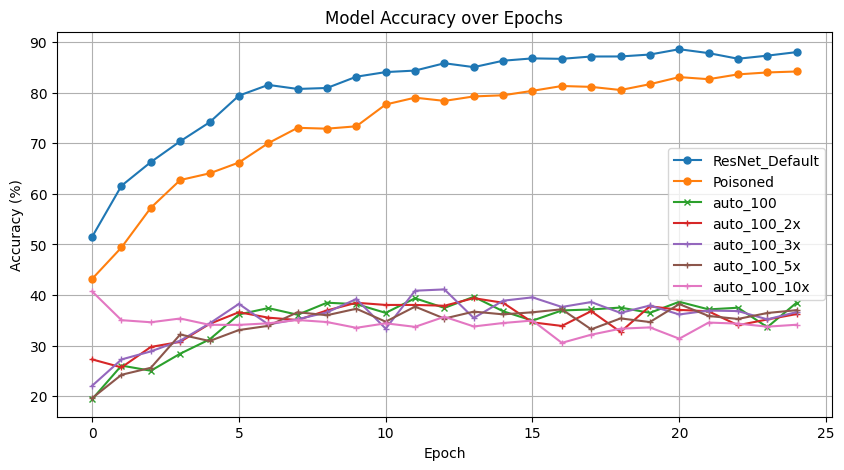

In [76]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
plt.plot(acc_auto_100_2x, marker='+', linestyle='-', markersize=5, label='auto_100_2x')
plt.plot(acc_auto_100_3x, marker='+', linestyle='-', markersize=5, label='auto_100_3x')
plt.plot(acc_auto_100_5x, marker='+', linestyle='-', markersize=5, label='auto_100_5x')
plt.plot(acc_auto_100_10x, marker='+', linestyle='-', markersize=5, label='auto_100_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()

#### unet_100

In [77]:
train_loader_unet_100_2x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_2x = train_and_evaluate(model_unet_100_2x, train_loader_unet_100_2x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_2x.pt", log_name = "unet_100_2x")

Number of Data Type: 6
[Epoch 1] loss: 2.274
Accuracy: 10.00%
[Epoch 2] loss: 2.198
Accuracy: 10.00%
[Epoch 3] loss: 2.156
Accuracy: 10.00%
[Epoch 4] loss: 2.127
Accuracy: 10.00%
[Epoch 5] loss: 2.099
Accuracy: 10.00%
[Epoch 6] loss: 2.075
Accuracy: 10.00%
[Epoch 7] loss: 2.047
Accuracy: 10.00%
[Epoch 8] loss: 2.019
Accuracy: 10.00%
[Epoch 9] loss: 1.984
Accuracy: 10.00%
[Epoch 10] loss: 1.945
Accuracy: 10.00%
[Epoch 11] loss: 1.900
Accuracy: 10.00%
[Epoch 12] loss: 1.847
Accuracy: 10.00%
[Epoch 13] loss: 1.785
Accuracy: 10.00%
[Epoch 14] loss: 1.721
Accuracy: 10.00%
[Epoch 15] loss: 1.642
Accuracy: 10.00%
[Epoch 16] loss: 1.581
Accuracy: 10.00%
[Epoch 17] loss: 1.511
Accuracy: 10.00%
[Epoch 18] loss: 1.447
Accuracy: 10.00%
[Epoch 19] loss: 1.403
Accuracy: 10.00%
[Epoch 20] loss: 1.364
Accuracy: 10.00%
[Epoch 21] loss: 1.334
Accuracy: 10.00%
[Epoch 22] loss: 1.308
Accuracy: 10.33%
[Epoch 23] loss: 1.288
Accuracy: 10.00%
[Epoch 24] loss: 1.280
Accuracy: 10.00%
[Epoch 25] loss: 1.272
Acc

In [78]:
train_loader_unet_100_3x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_3x = train_and_evaluate(model_unet_100_3x, train_loader_unet_100_3x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_3x.pt", log_name = "unet_100_3x")

Number of Data Type: 6
[Epoch 1] loss: 2.285
Accuracy: 10.00%
[Epoch 2] loss: 2.204
Accuracy: 10.00%
[Epoch 3] loss: 2.159
Accuracy: 10.00%
[Epoch 4] loss: 2.127
Accuracy: 10.00%
[Epoch 5] loss: 2.099
Accuracy: 10.00%
[Epoch 6] loss: 2.072
Accuracy: 10.00%
[Epoch 7] loss: 2.041
Accuracy: 10.00%
[Epoch 8] loss: 2.008
Accuracy: 10.00%
[Epoch 9] loss: 1.973
Accuracy: 10.00%
[Epoch 10] loss: 1.928
Accuracy: 9.98%
[Epoch 11] loss: 1.876
Accuracy: 10.00%
[Epoch 12] loss: 1.819
Accuracy: 10.00%
[Epoch 13] loss: 1.754
Accuracy: 10.00%
[Epoch 14] loss: 1.674
Accuracy: 10.00%
[Epoch 15] loss: 1.597
Accuracy: 10.00%
[Epoch 16] loss: 1.524
Accuracy: 10.00%
[Epoch 17] loss: 1.463
Accuracy: 10.15%
[Epoch 18] loss: 1.396
Accuracy: 12.58%
[Epoch 19] loss: 1.348
Accuracy: 15.34%
[Epoch 20] loss: 1.323
Accuracy: 14.35%
[Epoch 21] loss: 1.286
Accuracy: 16.14%
[Epoch 22] loss: 1.246
Accuracy: 19.58%
[Epoch 23] loss: 1.222
Accuracy: 20.00%
[Epoch 24] loss: 1.204
Accuracy: 27.58%
[Epoch 25] loss: 1.183
Accu

In [79]:
train_loader_unet_100_5x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_5x = train_and_evaluate(model_unet_100_5x, train_loader_unet_100_5x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_5x.pt", log_name = "unet_100_5x")

Number of Data Type: 6
[Epoch 1] loss: 2.286
Accuracy: 10.00%
[Epoch 2] loss: 2.208
Accuracy: 10.00%
[Epoch 3] loss: 2.158
Accuracy: 10.00%
[Epoch 4] loss: 2.126
Accuracy: 10.00%
[Epoch 5] loss: 2.099
Accuracy: 10.00%
[Epoch 6] loss: 2.073
Accuracy: 10.00%
[Epoch 7] loss: 2.044
Accuracy: 10.00%
[Epoch 8] loss: 2.015
Accuracy: 10.00%
[Epoch 9] loss: 1.980
Accuracy: 10.00%
[Epoch 10] loss: 1.943
Accuracy: 10.00%
[Epoch 11] loss: 1.896
Accuracy: 10.00%
[Epoch 12] loss: 1.849
Accuracy: 10.00%
[Epoch 13] loss: 1.790
Accuracy: 10.00%
[Epoch 14] loss: 1.729
Accuracy: 10.00%
[Epoch 15] loss: 1.658
Accuracy: 10.00%
[Epoch 16] loss: 1.590
Accuracy: 10.00%
[Epoch 17] loss: 1.527
Accuracy: 10.00%
[Epoch 18] loss: 1.457
Accuracy: 10.00%
[Epoch 19] loss: 1.419
Accuracy: 10.00%
[Epoch 20] loss: 1.369
Accuracy: 10.00%
[Epoch 21] loss: 1.343
Accuracy: 10.00%
[Epoch 22] loss: 1.316
Accuracy: 10.00%
[Epoch 23] loss: 1.295
Accuracy: 9.99%
[Epoch 24] loss: 1.291
Accuracy: 10.00%
[Epoch 25] loss: 1.268
Accu

In [80]:
train_loader_unet_100_10x = DataLoader(dataset=s_unet_100, batch_size=64, shuffle=True)

acc_unet_100_10x = train_and_evaluate(model_unet_100_2x, train_loader_unet_100_10x, test_loader, net_reset=(multiplier_sys_reset or M_reset_unet_100), net_name="unet_100_10x.pt", log_name = "unet_100_10x")

Number of Data Type: 6
[Epoch 1] loss: 1.821
Accuracy: 12.34%
[Epoch 2] loss: 1.350
Accuracy: 10.00%
[Epoch 3] loss: 1.260
Accuracy: 10.00%
[Epoch 4] loss: 1.249
Accuracy: 10.00%
[Epoch 5] loss: 1.245
Accuracy: 10.00%
[Epoch 6] loss: 1.234
Accuracy: 10.00%
[Epoch 7] loss: 1.233
Accuracy: 10.00%
[Epoch 8] loss: 1.230
Accuracy: 10.87%
[Epoch 9] loss: 1.230
Accuracy: 10.02%
[Epoch 10] loss: 1.225
Accuracy: 10.42%
[Epoch 11] loss: 1.211
Accuracy: 12.26%
[Epoch 12] loss: 1.210
Accuracy: 14.48%
[Epoch 13] loss: 1.211
Accuracy: 15.06%
[Epoch 14] loss: 1.209
Accuracy: 17.26%
[Epoch 15] loss: 1.184
Accuracy: 19.79%
[Epoch 16] loss: 1.174
Accuracy: 21.85%
[Epoch 17] loss: 1.160
Accuracy: 23.21%
[Epoch 18] loss: 1.140
Accuracy: 22.76%
[Epoch 19] loss: 1.120
Accuracy: 25.85%
[Epoch 20] loss: 1.107
Accuracy: 28.39%
[Epoch 21] loss: 1.082
Accuracy: 26.22%
[Epoch 22] loss: 1.037
Accuracy: 25.27%
[Epoch 23] loss: 1.027
Accuracy: 26.35%
[Epoch 24] loss: 0.989
Accuracy: 25.40%
[Epoch 25] loss: 0.958
Acc

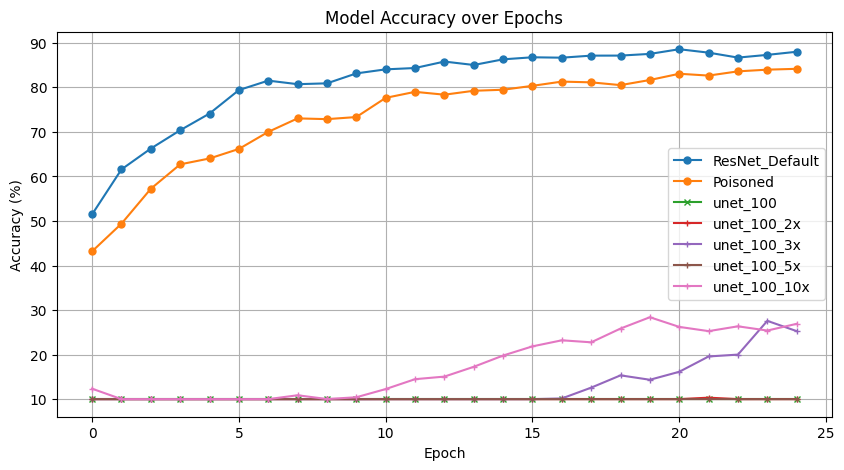

In [81]:
# Visualize the test accuracy
plt.figure(figsize=(10, 5))

plt.plot(acc_res, marker='o', linestyle='-', markersize=5, label='ResNet_Default')
plt.plot(acc_res_1, marker='o', linestyle='-', markersize=5, label='Poisoned')
plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')
plt.plot(acc_unet_100_2x, marker='+', linestyle='-', markersize=5, label='unet_100_2x')
plt.plot(acc_unet_100_3x, marker='+', linestyle='-', markersize=5, label='unet_100_3x')
plt.plot(acc_unet_100_5x, marker='+', linestyle='-', markersize=5, label='unet_100_5x')
plt.plot(acc_unet_100_10x, marker='+', linestyle='-', markersize=5, label='unet_100_10x')
# plt.plot(acc_unet_10, marker='x', linestyle='-', markersize=5, label='unet_10')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='auto_attack')
# plt.plot(acc_auto_attack, marker='x', linestyle='-', markersize=5, label='unet_attack')
# plt.plot(acc_auto_100, marker='x', linestyle='-', markersize=5, label='auto_100')
# plt.plot(acc_unet_100, marker='x', linestyle='-', markersize=5, label='unet_100')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.grid(True)
plt.legend()
plt.show()